# FORECASTING U.S. RENTAL AFFORDABILITY
**PROJECT OVERVIEW**

This project builds predictive models to forecast monthly rental prices across top 20 U.S. metros.

**Research Question**: Can we accurately forecast rent levels through 2026?

**Methodology**: Compare Naive, Linear Regression, Ridge, Random Forest, XGBoost, ARIMA, and Ensemble models


PART 1: DATA PREPARATION & FEATURE ENGINEERING

In [1]:
# Install Required Packages
import sys
!{sys.executable} -m pip install fredapi pmdarima xgboost --quiet

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from fredapi import Fred
import warnings
warnings.filterwarnings('ignore')

print("All packages imported successfully")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 689.1/689.1 kB 18.4 MB/s eta 0:00:00
All packages imported successfully


In [2]:
# API Keys and Data URLs
FRED_KEY = "bd72e6a54f9ebca86d3fd8598dcaeaa6"
ZORI_URL = "https://files.zillowstatic.com/research/public_csvs/zori/Metro_zori_uc_sfrcondomfr_sm_month.csv"

print(f"FRED API Key: {FRED_KEY[:10]}...")
print(f"ZORI Data URL configured")

FRED API Key: bd72e6a54f...
ZORI Data URL configured


In [3]:
# Load Zillow Rent Data
zori_raw = pd.read_csv(ZORI_URL)
print(f"Original ZORI shape: {zori_raw.shape}")

# Identify metro identifier columns
id_cols = [c for c in zori_raw.columns if not c[:2].isdigit()]

# Reshape from wide to long format
zori = zori_raw.melt(id_vars=id_cols, var_name="Date", value_name="Rent")

# Clean and standardize
zori = zori.rename(columns={"RegionName": "Metro", "StateName": "State"})
zori["Date"] = pd.to_datetime(zori["Date"], errors="coerce")
zori = zori.dropna(subset=["Date", "Rent"])
zori = zori.sort_values(["Metro", "Date"]).reset_index(drop=True)

print(f"Reshaped ZORI shape: {zori.shape}")
print(f"Date range: {zori['Date'].min()} to {zori['Date'].max()}")
zori.head()

Original ZORI shape: (692, 136)
Reshaped ZORI shape: (47811, 7)
Date range: 2015-01-31 00:00:00 to 2025-11-30 00:00:00


,RegionID,SizeRank,Metro,RegionType,State,Date,Rent
0,394297,677,"Aberdeen, SD",msa,SD,2025-05-31,901.936542
1,394297,677,"Aberdeen, SD",msa,SD,2025-06-30,926.396326
2,394297,677,"Aberdeen, SD",msa,SD,2025-07-31,977.964418
3,394297,677,"Aberdeen, SD",msa,SD,2025-08-31,989.746347
4,394297,677,"Aberdeen, SD",msa,SD,2025-09-30,969.551983


In [4]:
# Load Federal Reserve Economic Data
fred = Fred(api_key=FRED_KEY)

# Fetch median household income (annual)
income_df = fred.get_series("MEHOINUSA672N").to_frame("Income").reset_index()
income_df = income_df.rename(columns={"index": "Date"})
income_df["Date"] = pd.to_datetime(income_df["Date"])
income_df["Year"] = income_df["Date"].dt.year

print(f"Income data shape: {income_df.shape}")
print(f"Income range: {income_df['Year'].min()} - {income_df['Year'].max()}")
income_df.tail()

Income data shape: (41, 3)
Income range: 1984 - 2024


,Date,Income,Year
36,2020-01-01,81580.0,2020
37,2021-01-01,81270.0,2021
38,2022-01-01,79500.0,2022
39,2023-01-01,82690.0,2023
40,2024-01-01,83730.0,2024


In [5]:
# Load Consumer Price Index
cpi_df = fred.get_series("CPIAUCSL").to_frame("CPI").reset_index()
cpi_df = cpi_df.rename(columns={"index": "Date"})
cpi_df["Date"] = pd.to_datetime(cpi_df["Date"])

print(f"CPI data shape: {cpi_df.shape}")
print(f"CPI date range: {cpi_df['Date'].min()} - {cpi_df['Date'].max()}")
cpi_df.tail()

CPI data shape: (947, 2)
CPI date range: 1947-01-01 00:00:00 - 2025-11-01 00:00:00


,Date,CPI
942,2025-07-01,322.132
943,2025-08-01,323.364
944,2025-09-01,324.368
945,2025-10-01,NaN
946,2025-11-01,325.031


In [6]:
# Merge All Data Sources
merged = zori.merge(cpi_df, on="Date", how="left")

# Create year column for income merge
merged["Year"] = merged["Date"].dt.year

# Build complete yearly income table with forward fill
full_year_min = int(merged["Year"].min())
full_year_max = int(merged["Year"].max())

income_yearly = (
    income_df[["Year", "Income"]]
    .drop_duplicates("Year")
    .set_index("Year")
    .reindex(range(full_year_min, full_year_max + 1))
    .ffill()
    .reset_index()
)

# Merge income by year
merged = merged.merge(income_yearly, on="Year", how="left")

# Fill any missing CPI values
merged["CPI"] = merged["CPI"].ffill().bfill()

print(f"Merged dataset shape: {merged.shape}")
print(f"Date range: {merged['Date'].min()} to {merged['Date'].max()}")
merged.head()

Merged dataset shape: (47811, 10)
Date range: 2015-01-31 00:00:00 to 2025-11-30 00:00:00


,RegionID,SizeRank,Metro,RegionType,State,Date,Rent,CPI,Year,Income
0,394297,677,"Aberdeen, SD",msa,SD,2025-05-31,901.936542,NaN,2025,83730.0
1,394297,677,"Aberdeen, SD",msa,SD,2025-06-30,926.396326,NaN,2025,83730.0
2,394297,677,"Aberdeen, SD",msa,SD,2025-07-31,977.964418,NaN,2025,83730.0
3,394297,677,"Aberdeen, SD",msa,SD,2025-08-31,989.746347,NaN,2025,83730.0
4,394297,677,"Aberdeen, SD",msa,SD,2025-09-30,969.551983,NaN,2025,83730.0


In [7]:
# Extract Time Features
merged["Month"] = merged["Date"].dt.month
merged["Year_Num"] = merged["Year"] - merged["Year"].min()
merged["Month_Num"] = (merged["Year"] - merged["Year"].min()) * 12 + merged["Month"]
merged["Quarter"] = merged["Date"].dt.quarter

print("Time features created:")
print(merged[["Date", "Month", "Year_Num", "Month_Num", "Quarter"]].head(10))

Time features created:
        Date  Month  Year_Num  Month_Num  Quarter
0 2025-05-31      5        10        125        2
1 2025-06-30      6        10        126        2
2 2025-07-31      7        10        127        3
3 2025-08-31      8        10        128        3
4 2025-09-30      9        10        129        3
5 2025-10-31     10        10        130        4
6 2025-11-30     11        10        131        4
7 2022-06-30      6         7         90        2
8 2022-07-31      7         7         91        3
9 2022-08-31      8         7         92        3


In [8]:
# Create Lag Features
merged = merged.sort_values(["Metro", "Date"]).reset_index(drop=True)

# Lag features for rent at different time points
merged["Rent_Lag_1"] = merged.groupby("Metro")["Rent"].shift(1)
merged["Rent_Lag_3"] = merged.groupby("Metro")["Rent"].shift(3)
merged["Rent_Lag_12"] = merged.groupby("Metro")["Rent"].shift(12)

print("Lag features created:")
print(merged[["Metro", "Date", "Rent", "Rent_Lag_1", "Rent_Lag_3", "Rent_Lag_12"]].head(15))

Lag features created:
           Metro       Date         Rent   Rent_Lag_1   Rent_Lag_3  \
0   Aberdeen, SD 2025-05-31   901.936542          NaN          NaN   
1   Aberdeen, SD 2025-06-30   926.396326   901.936542          NaN   
2   Aberdeen, SD 2025-07-31   977.964418   926.396326          NaN   
3   Aberdeen, SD 2025-08-31   989.746347   977.964418   901.936542   
4   Aberdeen, SD 2025-09-30   969.551983   989.746347   926.396326   
5   Aberdeen, SD 2025-10-31   947.057104   969.551983   977.964418   
6   Aberdeen, SD 2025-11-30   954.583333   947.057104   989.746347   
7   Aberdeen, WA 2022-06-30  1258.461217          NaN          NaN   
8   Aberdeen, WA 2022-07-31  1246.633643  1258.461217          NaN   
9   Aberdeen, WA 2022-08-31  1259.483964  1246.633643          NaN   
10  Aberdeen, WA 2022-09-30  1256.973019  1259.483964  1258.461217   
11  Aberdeen, WA 2022-10-31  1263.737071  1256.973019  1246.633643   
12  Aberdeen, WA 2022-11-30  1288.325094  1263.737071  1259.483964  

In [9]:
# Create Rolling Average Features
merged["Rent_Roll_3"] = merged.groupby("Metro")["Rent"].transform(lambda x: x.rolling(3, min_periods=1).mean())
merged["Rent_Roll_6"] = merged.groupby("Metro")["Rent"].transform(lambda x: x.rolling(6, min_periods=1).mean())
merged["Rent_Roll_12"] = merged.groupby("Metro")["Rent"].transform(lambda x: x.rolling(12, min_periods=1).mean())

print("Rolling average features created:")
print(merged[["Metro", "Date", "Rent", "Rent_Roll_3", "Rent_Roll_6", "Rent_Roll_12"]].tail(10))

Rolling average features created:
                Metro       Date         Rent  Rent_Roll_3  Rent_Roll_6  \
47801  Zanesville, OH 2025-02-28  1008.211935  1018.468402  1009.368571   
47802  Zanesville, OH 2025-03-31  1016.031794  1015.510236  1016.937160   
47803  Zanesville, OH 2025-04-30   995.438332  1006.560687  1014.188018   
47804  Zanesville, OH 2025-05-31  1015.913093  1009.127740  1013.798071   
47805  Zanesville, OH 2025-06-30  1040.003037  1017.118154  1016.314195   
47806  Zanesville, OH 2025-07-31  1083.799410  1046.571847  1026.566267   
47807  Zanesville, OH 2025-08-31  1092.388021  1072.063489  1040.595614   
47808  Zanesville, OH 2025-09-30  1096.855526  1091.014319  1054.066236   
47809  Zanesville, OH 2025-10-31  1081.941259  1090.394935  1068.483391   
47810  Zanesville, OH 2025-11-30  1074.805556  1084.534113  1078.298801   

       Rent_Roll_12  
47801    985.546596  
47802    989.936946  
47803    993.632851  
47804    998.722047  
47805   1005.271340  
47806   

In [10]:
# Create Growth Rate Features
merged["Rent_Growth_MoM"] = merged.groupby("Metro")["Rent"].pct_change(1).fillna(0)
merged["Rent_Growth_YoY"] = merged.groupby("Metro")["Rent"].pct_change(12).fillna(0)

print("Growth rate features created:")
print(merged[["Metro", "Date", "Rent", "Rent_Growth_MoM", "Rent_Growth_YoY"]].tail(10))

Growth rate features created:
                Metro       Date         Rent  Rent_Growth_MoM  \
47801  Zanesville, OH 2025-02-28  1008.211935        -0.013768   
47802  Zanesville, OH 2025-03-31  1016.031794         0.007756   
47803  Zanesville, OH 2025-04-30   995.438332        -0.020269   
47804  Zanesville, OH 2025-05-31  1015.913093         0.020569   
47805  Zanesville, OH 2025-06-30  1040.003037         0.023713   
47806  Zanesville, OH 2025-07-31  1083.799410         0.042112   
47807  Zanesville, OH 2025-08-31  1092.388021         0.007925   
47808  Zanesville, OH 2025-09-30  1096.855526         0.004090   
47809  Zanesville, OH 2025-10-31  1081.941259        -0.013597   
47810  Zanesville, OH 2025-11-30  1074.805556        -0.006595   

       Rent_Growth_YoY  
47801         0.061163  
47802         0.054689  
47803         0.046632  
47804         0.063959  
47805         0.081746  
47806         0.125722  
47807         0.118220  
47808         0.130056  
47809         0.06

In [11]:
# Select Top 20 Metros by Average Rent
temp_clean = merged.dropna(subset=["Rent_Lag_1", "Rent_Lag_3", "Rent_Lag_12"]).copy()

# Calculate average rent per metro
metro_avg_rent = temp_clean.groupby("Metro")["Rent"].agg(['mean', 'count']).sort_values('mean', ascending=False)

# Filter to metros with at least 50 observations
metro_avg_rent = metro_avg_rent[metro_avg_rent['count'] >= 50]

# Select top 20 metros
top_20_metros = metro_avg_rent.head(20).index.tolist()

print("Top 20 Metros by Average Rent:")
for i, metro in enumerate(top_20_metros, 1):
    avg_rent = metro_avg_rent.loc[metro, 'mean']
    count = metro_avg_rent.loc[metro, 'count']
    print(f"{i:2d}. {metro:45s} ${avg_rent:,.0f}  ({count:.0f} months)")

# Filter dataset to top 20 metros
merged_top20 = merged[merged["Metro"].isin(top_20_metros)].copy()
print(f"\nFiltered dataset shape: {merged_top20.shape}")
print(f"Date range: {merged_top20['Date'].min()} to {merged_top20['Date'].max()}")

Top 20 Metros by Average Rent:
 1. San Jose, CA                                  $2,986  (119 months)
 2. Key West, FL                                  $2,901  (86 months)
 3. Santa Cruz, CA                                $2,796  (119 months)
 4. Heber, UT                                     $2,785  (70 months)
 5. San Francisco, CA                             $2,739  (117 months)
 6. New York, NY                                  $2,659  (117 months)
 7. Napa, CA                                      $2,562  (104 months)
 8. Santa Maria, CA                               $2,520  (119 months)
 9. Glenwood Springs, CO                          $2,459  (104 months)
10. Boston, MA                                    $2,448  (117 months)
11. Los Angeles, CA                               $2,411  (119 months)
12. Oxnard, CA                                    $2,386  (119 months)
13. San Diego, CA                                 $2,336  (119 months)
14. Barnstable Town, MA                         

In [12]:
# Create Train/Validation/Test Splits
train_end = "2023-12-31"
val_end = "2024-12-31"

train = merged_top20[merged_top20["Date"] <= train_end].copy()
validation = merged_top20[(merged_top20["Date"] > train_end) & (merged_top20["Date"] <= val_end)].copy()
test = merged_top20[merged_top20["Date"] > val_end].copy()

print("Dataset Splits:")
print(f"Train:      {train['Date'].min()} to {train['Date'].max()} | {len(train):,} rows")
print(f"Validation: {validation['Date'].min()} to {validation['Date'].max()} | {len(validation):,} rows")
print(f"Test:       {test['Date'].min()} to {test['Date'].max()} | {len(test):,} rows")
print(f"\nTotal:      {len(merged_top20):,} rows")

Dataset Splits:
Train:      2015-01-31 00:00:00 to 2023-12-31 00:00:00 | 1,991 rows
Validation: 2024-01-31 00:00:00 to 2024-12-31 00:00:00 | 240 rows
Test:       2025-01-31 00:00:00 to 2025-11-30 00:00:00 | 220 rows

Total:      2,451 rows


In [13]:
# Remove Rows with Missing Lag Values
train_clean = train.dropna(subset=["Rent_Lag_1", "Rent_Lag_3", "Rent_Lag_12"]).reset_index(drop=True)
validation_clean = validation.dropna(subset=["Rent_Lag_1", "Rent_Lag_3", "Rent_Lag_12"]).reset_index(drop=True)
test_clean = test.dropna(subset=["Rent_Lag_1", "Rent_Lag_3", "Rent_Lag_12"]).reset_index(drop=True)

print("After removing NaN lag values:")
print(f"Train:      {len(train_clean):,} rows")
print(f"Validation: {len(validation_clean):,} rows")
print(f"Test:       {len(test_clean):,} rows")

After removing NaN lag values:
Train:      1,751 rows
Validation: 240 rows
Test:       220 rows


In [14]:
# Save Processed Data
import os

# Create necessary folders
os.makedirs("data/processed", exist_ok=True)
os.makedirs("data/raw", exist_ok=True)
os.makedirs("figures", exist_ok=True)
os.makedirs("models", exist_ok=True)

# Save datasets
merged_top20.to_csv("data/processed/merged_top20_all.csv", index=False)
train_clean.to_csv("data/processed/train.csv", index=False)
validation_clean.to_csv("data/processed/validation.csv", index=False)
test_clean.to_csv("data/processed/test.csv", index=False)

print("Data saved successfully to data/processed/")

Data saved successfully to data/processed/


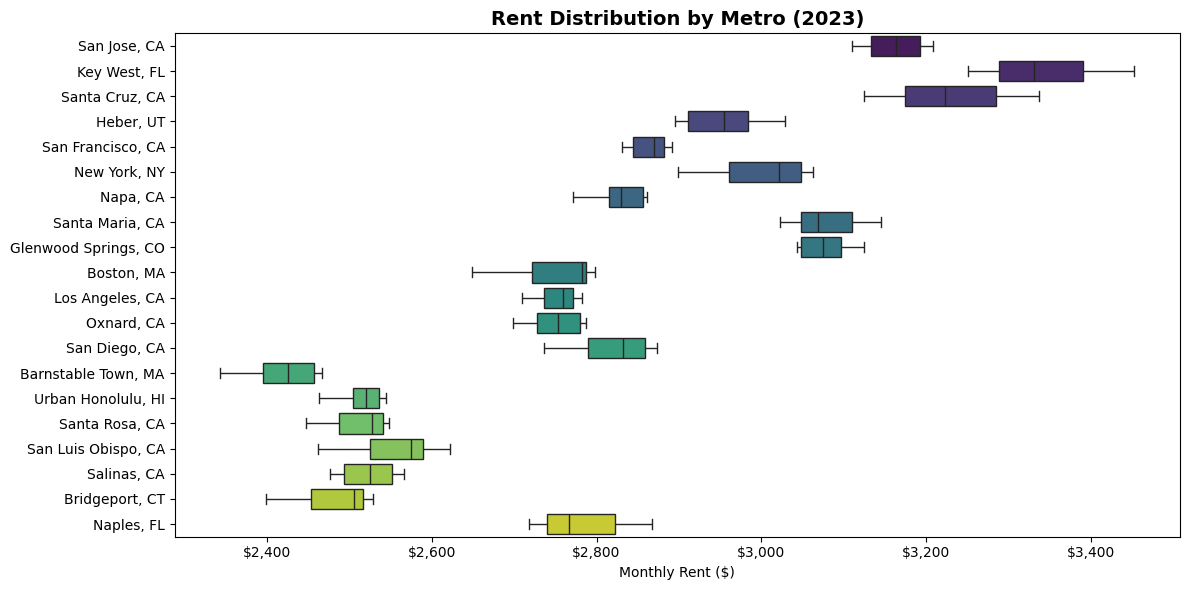

Figure saved: figures/rent_distribution_top20.png


In [15]:
# Visualization 1: Rent Distribution by Metro
os.makedirs("figures", exist_ok=True)

latest_year = train_clean[train_clean["Year"] == train_clean["Year"].max()]

plt.figure(figsize=(12, 6))
sns.boxplot(data=latest_year, x="Rent", y="Metro", order=top_20_metros, palette="viridis")
plt.title("Rent Distribution by Metro (2023)", fontsize=14, fontweight="bold")
plt.xlabel("Monthly Rent ($)")
plt.ylabel("")

from matplotlib.ticker import FuncFormatter
def currency(x, pos):
    return f'${x:,.0f}'
plt.gca().xaxis.set_major_formatter(FuncFormatter(currency))

plt.tight_layout()
plt.savefig("figures/rent_distribution_top20.png", dpi=300, bbox_inches="tight")
plt.show()

print("Figure saved: figures/rent_distribution_top20.png")

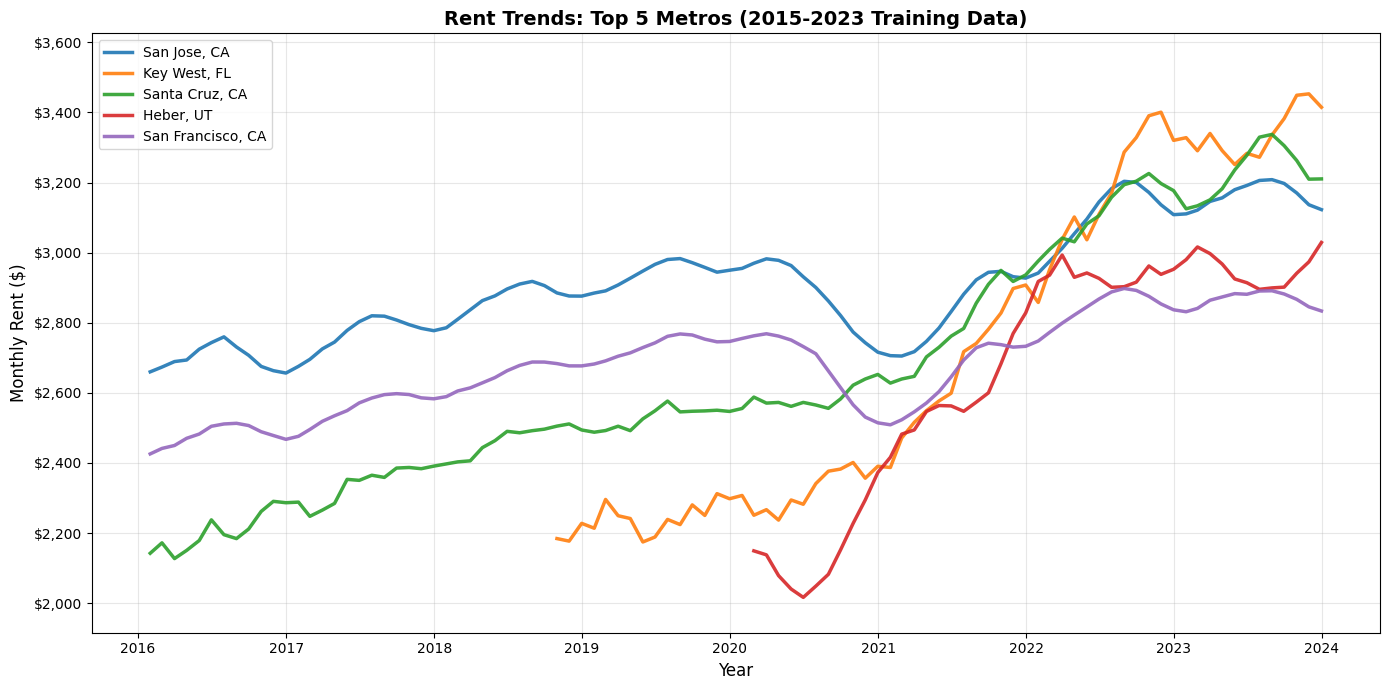

Figure saved: figures/rent_trends_sample.png


In [16]:
# Visualization 2: Rent Trends for Top 5 Metros
train_clean['Date'] = pd.to_datetime(train_clean['Date'])
sample_metros = top_20_metros[:5]

fig, ax = plt.subplots(figsize=(14, 7))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

for i, metro in enumerate(sample_metros):
    metro_data = train_clean[train_clean["Metro"] == metro].copy()
    metro_data = metro_data.sort_values('Date')

    if len(metro_data) > 0:
        ax.plot(metro_data["Date"], metro_data["Rent"],
               label=metro, linewidth=2.5, alpha=0.9, color=colors[i])

ax.set_title("Rent Trends: Top 5 Metros (2015-2023 Training Data)", fontsize=14, fontweight="bold")
ax.set_xlabel("Year", fontsize=12)
ax.set_ylabel("Monthly Rent ($)", fontsize=12)
ax.legend(loc="best", fontsize=10)
ax.grid(alpha=0.3)
ax.yaxis.set_major_formatter(FuncFormatter(currency))

rent_min = train_clean[train_clean["Metro"].isin(sample_metros)]["Rent"].min()
rent_max = train_clean[train_clean["Metro"].isin(sample_metros)]["Rent"].max()
ax.set_ylim([rent_min * 0.95, rent_max * 1.05])

plt.tight_layout()
plt.savefig("figures/rent_trends_sample.png", dpi=300, bbox_inches="tight")
plt.show()

print("Figure saved: figures/rent_trends_sample.png")

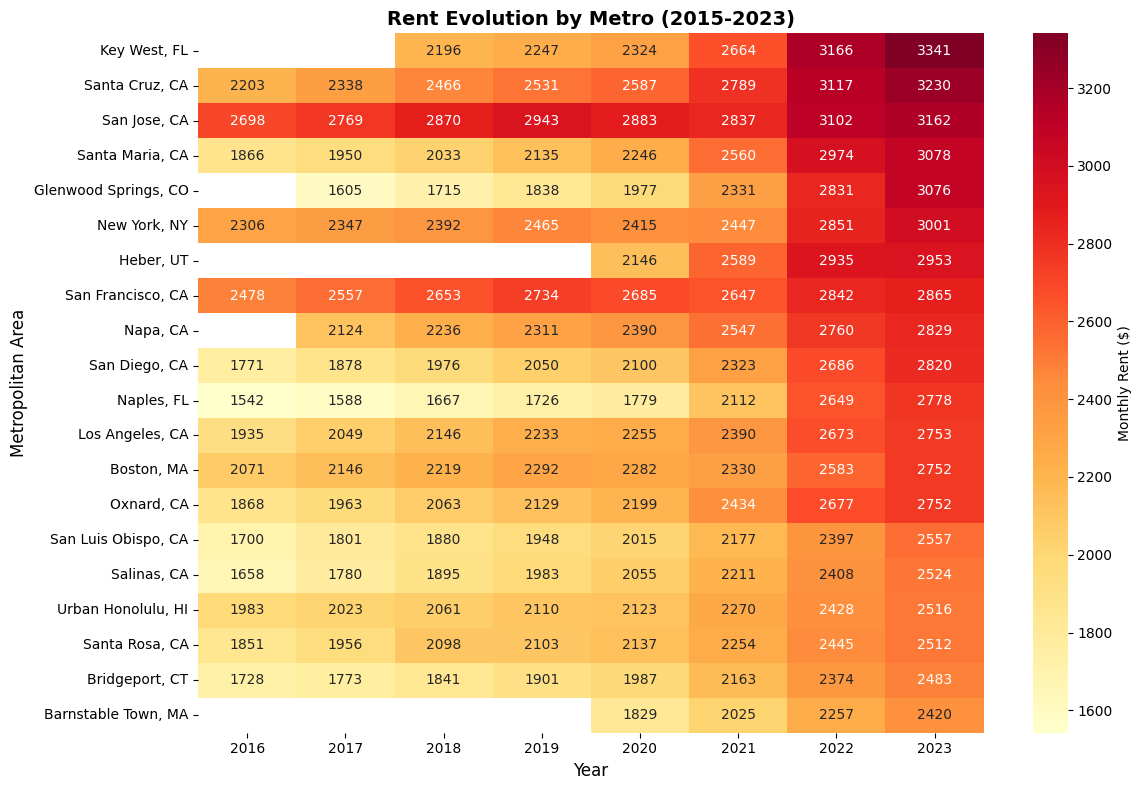

Figure saved: figures/rent_heatmap_by_metro_year.png


In [17]:
# Visualization 3: Rent Heatmap by Metro and Year
fig, ax = plt.subplots(figsize=(12, 8))

rent_by_year = train_clean.groupby(['Metro', 'Year'])['Rent'].mean().reset_index()
rent_pivot = rent_by_year.pivot(index='Metro', columns='Year', values='Rent')
rent_pivot = rent_pivot.sort_values(2023, ascending=False)

sns.heatmap(rent_pivot, annot=True, fmt='.0f', cmap='YlOrRd',
            cbar_kws={'label': 'Monthly Rent ($)'}, ax=ax)
ax.set_title('Rent Evolution by Metro (2015-2023)', fontsize=14, fontweight='bold')
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Metropolitan Area', fontsize=12)

plt.tight_layout()
plt.savefig('figures/rent_heatmap_by_metro_year.png', dpi=300, bbox_inches='tight')
plt.show()

print("Figure saved: figures/rent_heatmap_by_metro_year.png")

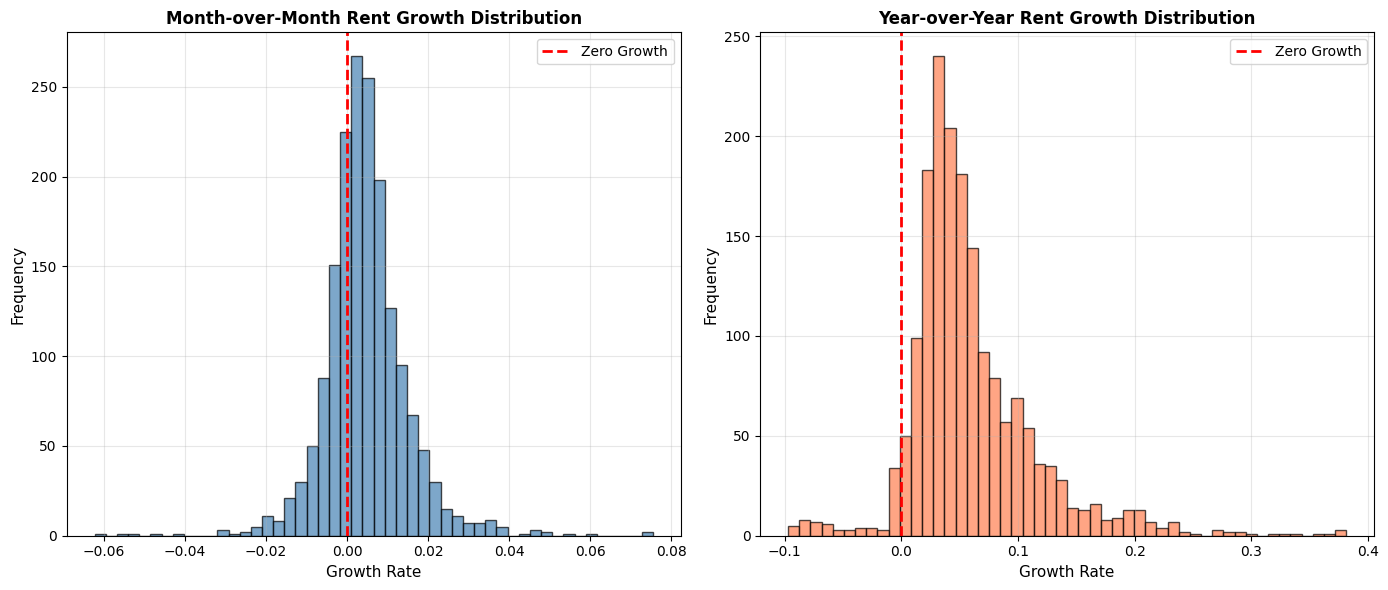

MoM Growth - Mean: 0.0046, Std: 0.0104
YoY Growth - Mean: 0.0601, Std: 0.0550
Figure saved: figures/rent_growth_distributions.png


In [18]:
# Visualization 4: Rent Growth Distributions
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Month-over-month growth
axes[0].hist(train_clean['Rent_Growth_MoM'].dropna(), bins=50,
             edgecolor='black', alpha=0.7, color='steelblue')
axes[0].axvline(0, color='red', linestyle='--', linewidth=2, label='Zero Growth')
axes[0].set_title('Month-over-Month Rent Growth Distribution', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Growth Rate', fontsize=11)
axes[0].set_ylabel('Frequency', fontsize=11)
axes[0].legend()
axes[0].grid(alpha=0.3)

# Year-over-year growth
axes[1].hist(train_clean['Rent_Growth_YoY'].dropna(), bins=50,
             edgecolor='black', alpha=0.7, color='coral')
axes[1].axvline(0, color='red', linestyle='--', linewidth=2, label='Zero Growth')
axes[1].set_title('Year-over-Year Rent Growth Distribution', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Growth Rate', fontsize=11)
axes[1].set_ylabel('Frequency', fontsize=11)
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('figures/rent_growth_distributions.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"MoM Growth - Mean: {train_clean['Rent_Growth_MoM'].mean():.4f}, Std: {train_clean['Rent_Growth_MoM'].std():.4f}")
print(f"YoY Growth - Mean: {train_clean['Rent_Growth_YoY'].mean():.4f}, Std: {train_clean['Rent_Growth_YoY'].std():.4f}")
print("Figure saved: figures/rent_growth_distributions.png")

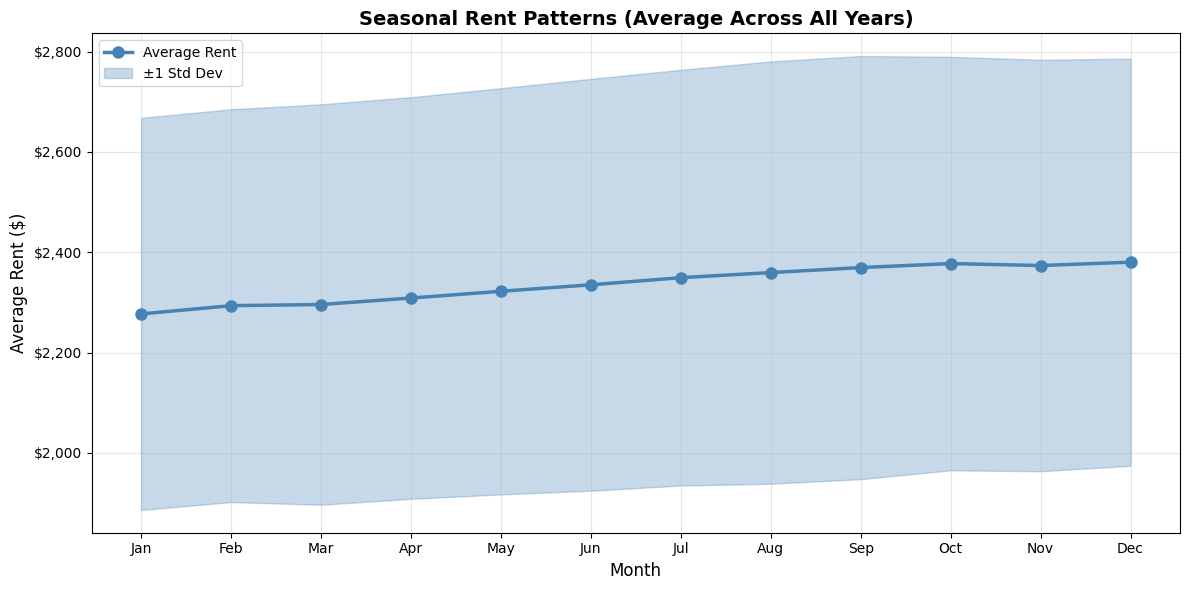

Figure saved: figures/seasonal_patterns.png


In [19]:
# Visualization 5: Seasonal Patterns
fig, ax = plt.subplots(figsize=(12, 6))

monthly_avg = train_clean.groupby('Month')['Rent'].mean().reset_index()
monthly_std = train_clean.groupby('Month')['Rent'].std().reset_index()

months_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

ax.plot(monthly_avg['Month'], monthly_avg['Rent'], 'o-',
        linewidth=2.5, markersize=8, color='steelblue', label='Average Rent')
ax.fill_between(monthly_avg['Month'],
                monthly_avg['Rent'] - monthly_std['Rent'],
                monthly_avg['Rent'] + monthly_std['Rent'],
                alpha=0.3, color='steelblue', label='±1 Std Dev')

ax.set_title('Seasonal Rent Patterns (Average Across All Years)', fontsize=14, fontweight='bold')
ax.set_xlabel('Month', fontsize=12)
ax.set_ylabel('Average Rent ($)', fontsize=12)
ax.set_xticks(range(1, 13))
ax.set_xticklabels(months_labels)
ax.legend()
ax.grid(alpha=0.3)
ax.yaxis.set_major_formatter(FuncFormatter(currency))

plt.tight_layout()
plt.savefig('figures/seasonal_patterns.png', dpi=300, bbox_inches='tight')
plt.show()

print("Figure saved: figures/seasonal_patterns.png")

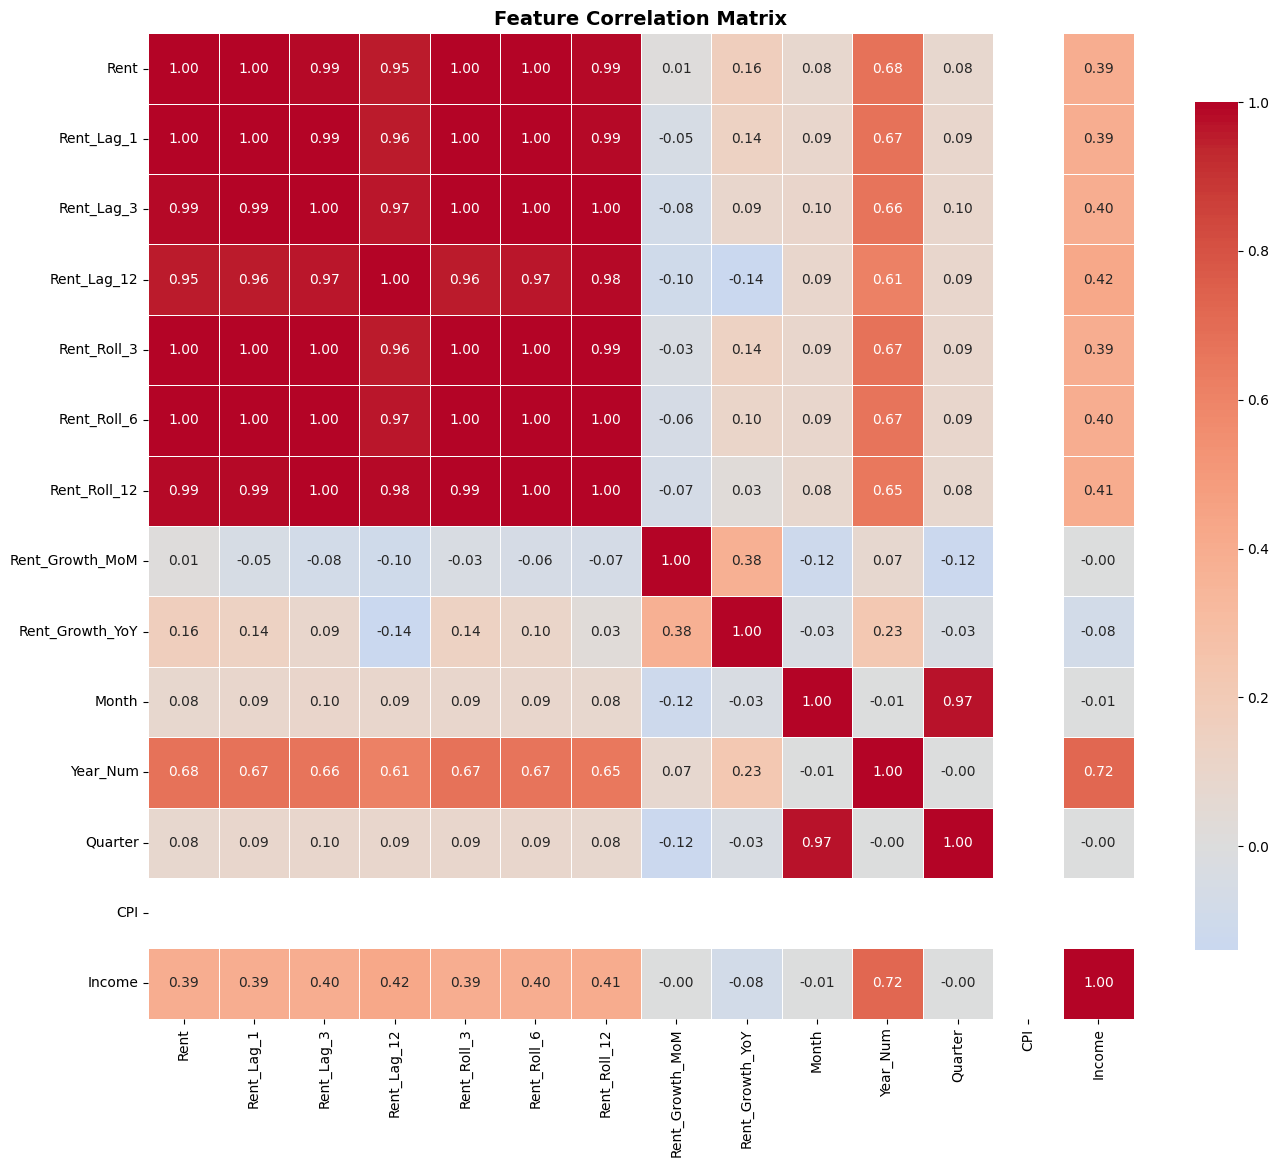

Figure saved: figures/correlation_heatmap.png


In [20]:
# Visualization 6: Correlation Heatmap
numeric_features = [
    'Rent', 'Rent_Lag_1', 'Rent_Lag_3', 'Rent_Lag_12',
    'Rent_Roll_3', 'Rent_Roll_6', 'Rent_Roll_12',
    'Rent_Growth_MoM', 'Rent_Growth_YoY',
    'Month', 'Year_Num', 'Quarter', 'CPI', 'Income'
]

corr_matrix = train_clean[numeric_features].corr()

fig, ax = plt.subplots(figsize=(14, 12))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8}, ax=ax)
ax.set_title('Feature Correlation Matrix', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('figures/correlation_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

print("Figure saved: figures/correlation_heatmap.png")

## PART 2: BASELINE MODELS



In [21]:
# Define Evaluation Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

def evaluate_predictions(y_true, y_pred, model_name="Model"):
    # Calculate standard forecasting metrics
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100

    print(f"\n{model_name} Performance:")
    print(f"  RMSE: ${rmse:,.2f}")
    print(f"  MAE:  ${mae:,.2f}")
    print(f"  MAPE: {mape:.2f}%")

    return {"Model": model_name, "RMSE": rmse, "MAE": mae, "MAPE": mape}

print("Evaluation metrics function defined")

Evaluation metrics function defined


In [22]:
# Naive Forecast Model
validation_naive = validation_clean.copy()
validation_naive["Prediction_Naive"] = validation_naive["Rent_Lag_1"]

test_naive = test_clean.copy()
test_naive["Prediction_Naive"] = test_naive["Rent_Lag_1"]

print("NAIVE FORECAST - VALIDATION SET (2024)")
naive_val_results = evaluate_predictions(
    validation_naive["Rent"],
    validation_naive["Prediction_Naive"],
    "Naive Forecast (Validation)"
)

print("\nNAIVE FORECAST - TEST SET (2025)")
naive_test_results = evaluate_predictions(
    test_naive["Rent"],
    test_naive["Prediction_Naive"],
    "Naive Forecast (Test)"
)

print("\nSample Naive Predictions:")
print(test_naive[["Date", "Metro", "Rent", "Rent_Lag_1", "Prediction_Naive"]].head(10).to_string(index=False))

NAIVE FORECAST - VALIDATION SET (2024)

Naive Forecast (Validation) Performance:
  RMSE: $20.53
  MAE:  $16.08
  MAPE: 0.55%

NAIVE FORECAST - TEST SET (2025)

Naive Forecast (Test) Performance:
  RMSE: $30.76
  MAE:  $20.33
  MAPE: 0.67%

Sample Naive Predictions:
      Date               Metro        Rent  Rent_Lag_1  Prediction_Naive
2025-01-31 Barnstable Town, MA 2512.715025 2525.807154       2525.807154
2025-02-28 Barnstable Town, MA 2546.528508 2512.715025       2512.715025
2025-03-31 Barnstable Town, MA 2613.613526 2546.528508       2546.528508
2025-04-30 Barnstable Town, MA 2683.183720 2613.613526       2613.613526
2025-05-31 Barnstable Town, MA 2661.173256 2683.183720       2683.183720
2025-06-30 Barnstable Town, MA 2676.753931 2661.173256       2661.173256
2025-07-31 Barnstable Town, MA 2677.551315 2676.753931       2676.753931
2025-08-31 Barnstable Town, MA 2718.479444 2677.551315       2677.551315
2025-09-30 Barnstable Town, MA 2658.180989 2718.479444       2718.479444
2025

In [23]:
# Linear Regression Setup
from sklearn.linear_model import LinearRegression

feature_cols = [
    "Month",
    "Year_Num",
    "Rent_Lag_1",
    "Rent_Lag_3",
    "Rent_Lag_12",
    "Rent_Roll_3",
]

target_col = "Rent"

print("Linear Regression Feature Set:")
for i, col in enumerate(feature_cols, 1):
    print(f"  {i}. {col}")
print(f"\nTarget Variable: {target_col}")

X_train = train_clean[feature_cols]
y_train = train_clean[target_col]

X_val = validation_clean[feature_cols]
y_val = validation_clean[target_col]

X_test = test_clean[feature_cols]
y_test = test_clean[target_col]

print(f"\nData shapes:")
print(f"  X_train: {X_train.shape}")
print(f"  X_val:   {X_val.shape}")
print(f"  X_test:  {X_test.shape}")

Linear Regression Feature Set:
  1. Month
  2. Year_Num
  3. Rent_Lag_1
  4. Rent_Lag_3
  5. Rent_Lag_12
  6. Rent_Roll_3

Target Variable: Rent

Data shapes:
  X_train: (1751, 6)
  X_val:   (240, 6)
  X_test:  (220, 6)


In [24]:
# Train Linear Regression Model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

print("\nFeature Coefficients:")
coef_df = pd.DataFrame({
    "Feature": feature_cols,
    "Coefficient": lr_model.coef_
}).sort_values("Coefficient", key=abs, ascending=False)

for idx, row in coef_df.iterrows():
    print(f"  {row['Feature']:20s} {row['Coefficient']:+10.4f}")

print(f"\nIntercept: ${lr_model.intercept_:,.2f}")


Feature Coefficients:
  Rent_Roll_3             +2.2495
  Rent_Lag_1              -0.8185
  Rent_Lag_3              -0.4368
  Year_Num                +0.4289
  Month                   -0.4239
  Rent_Lag_12             +0.0035

Intercept: $7.91


In [25]:
# Linear Regression Predictions
validation_lr = validation_clean.copy()
validation_lr["Prediction_LR"] = lr_model.predict(X_val)

test_lr = test_clean.copy()
test_lr["Prediction_LR"] = lr_model.predict(X_test)

print("LINEAR REGRESSION - VALIDATION SET (2024)")
lr_val_results = evaluate_predictions(
    validation_lr["Rent"],
    validation_lr["Prediction_LR"],
    "Linear Regression (Validation)"
)

print("\nLINEAR REGRESSION - TEST SET (2025)")
lr_test_results = evaluate_predictions(
    test_lr["Rent"],
    test_lr["Prediction_LR"],
    "Linear Regression (Test)"
)

print("\nSample Linear Regression Predictions:")
print(test_lr[["Date", "Metro", "Rent", "Prediction_LR"]].head(10).to_string(index=False))

LINEAR REGRESSION - VALIDATION SET (2024)

Linear Regression (Validation) Performance:
  RMSE: $9.12
  MAE:  $6.56
  MAPE: 0.22%

LINEAR REGRESSION - TEST SET (2025)

Linear Regression (Test) Performance:
  RMSE: $15.03
  MAE:  $9.42
  MAPE: 0.31%

Sample Linear Regression Predictions:
      Date               Metro        Rent  Prediction_LR
2025-01-31 Barnstable Town, MA 2512.715025    2507.093890
2025-02-28 Barnstable Town, MA 2546.528508    2550.614410
2025-03-31 Barnstable Town, MA 2613.613526    2585.407594
2025-04-30 Barnstable Town, MA 2683.183720    2663.723412
2025-05-31 Barnstable Town, MA 2661.173256    2677.536812
2025-06-30 Barnstable Town, MA 2676.753931    2713.113332
2025-07-31 Barnstable Town, MA 2677.551315    2665.345072
2025-08-31 Barnstable Town, MA 2718.479444    2716.943728
2025-09-30 Barnstable Town, MA 2658.180989    2662.129393
2025-10-31 Barnstable Town, MA 2614.379579    2663.350455


In [26]:
# Baseline Model Comparison
results_comparison = pd.DataFrame([
    naive_val_results,
    naive_test_results,
    lr_val_results,
    lr_test_results
])

print("BASELINE MODELS COMPARISON")
print(results_comparison.to_string(index=False))

print("\nLINEAR REGRESSION IMPROVEMENT OVER NAIVE")
rmse_improvement = ((naive_test_results["RMSE"] - lr_test_results["RMSE"]) / naive_test_results["RMSE"]) * 100
mae_improvement = ((naive_test_results["MAE"] - lr_test_results["MAE"]) / naive_test_results["MAE"]) * 100
mape_improvement = ((naive_test_results["MAPE"] - lr_test_results["MAPE"]) / naive_test_results["MAPE"]) * 100

print(f"RMSE Improvement: {rmse_improvement:+.1f}%")
print(f"MAE Improvement:  {mae_improvement:+.1f}%")
print(f"MAPE Improvement: {mape_improvement:+.1f}%")

results_comparison.to_csv("data/processed/baseline_results.csv", index=False)
print("\nResults saved to data/processed/baseline_results.csv")

BASELINE MODELS COMPARISON
                         Model      RMSE       MAE     MAPE
   Naive Forecast (Validation) 20.525941 16.084898 0.547970
         Naive Forecast (Test) 30.755287 20.328978 0.665123
Linear Regression (Validation)  9.115675  6.558589 0.223638
      Linear Regression (Test) 15.030047  9.423137 0.305567

LINEAR REGRESSION IMPROVEMENT OVER NAIVE
RMSE Improvement: +51.1%
MAE Improvement:  +53.6%
MAPE Improvement: +54.1%

Results saved to data/processed/baseline_results.csv


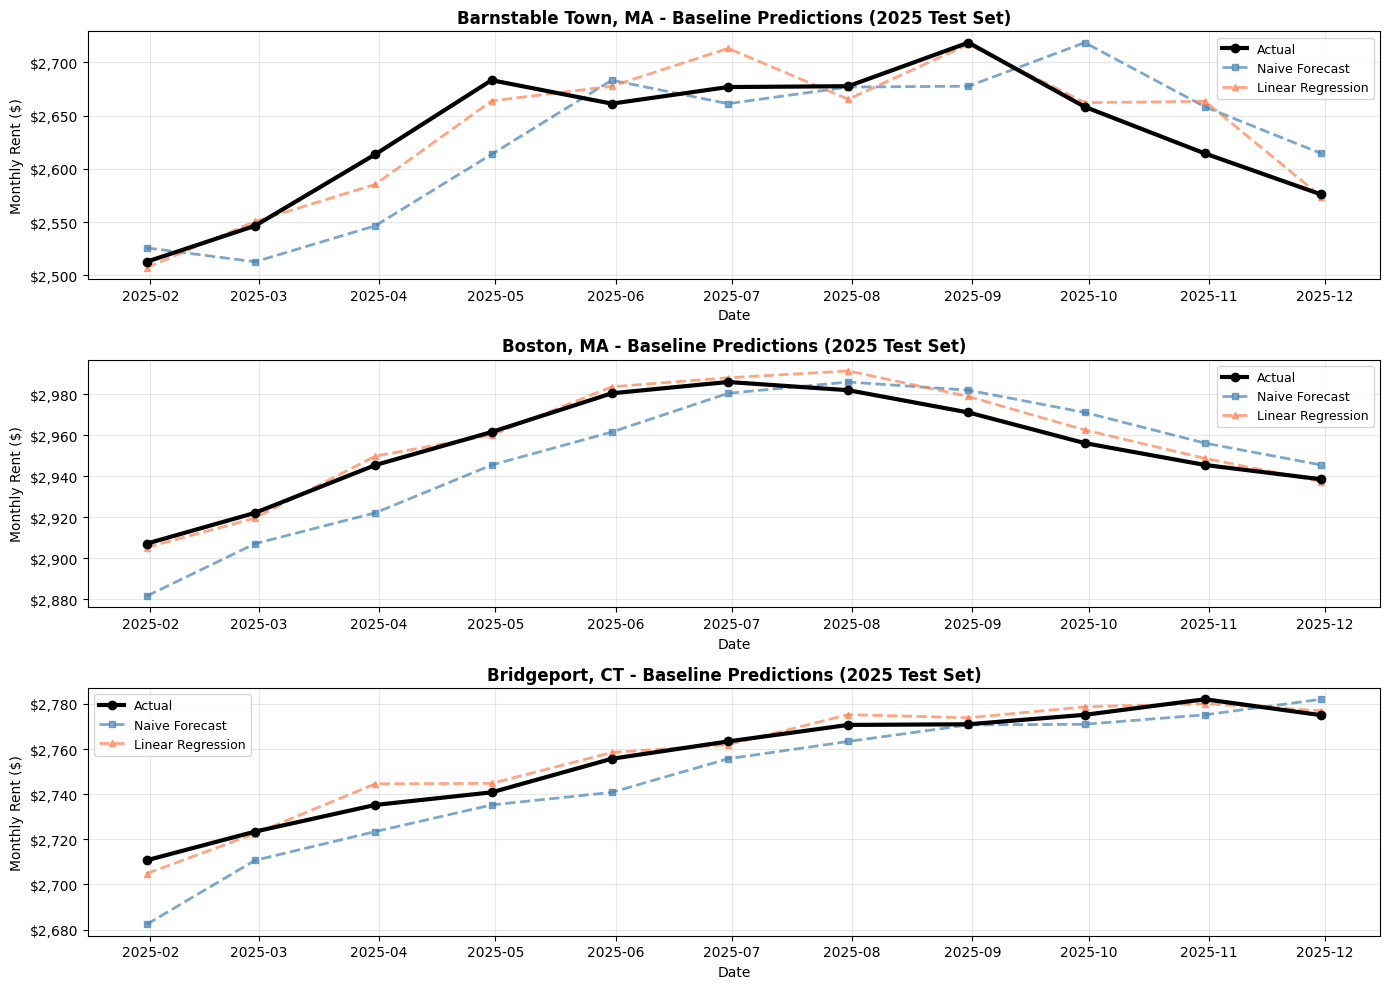

Figure saved: figures/baseline_predictions_sample.png


In [27]:
# Visualization 7: Baseline Predictions Sample
sample_metros = test_lr["Metro"].unique()[:3]

fig, axes = plt.subplots(3, 1, figsize=(14, 10))

for i, metro in enumerate(sample_metros):
    ax = axes[i]

    metro_test = test_lr[test_lr["Metro"] == metro].sort_values("Date")
    metro_naive = test_naive[test_naive["Metro"] == metro].sort_values("Date")

    ax.plot(metro_test["Date"], metro_test["Rent"],
            label="Actual", linewidth=3, marker='o', markersize=6, color='black', zorder=3)
    ax.plot(metro_naive["Date"], metro_naive["Prediction_Naive"],
            label="Naive Forecast", linewidth=2, linestyle='--', marker='s', markersize=5, alpha=0.7, color='steelblue')
    ax.plot(metro_test["Date"], metro_test["Prediction_LR"],
            label="Linear Regression", linewidth=2, linestyle='--', marker='^', markersize=5, alpha=0.7, color='coral')

    ax.set_title(f"{metro} - Baseline Predictions (2025 Test Set)", fontsize=12, fontweight='bold')
    ax.set_xlabel("Date", fontsize=10)
    ax.set_ylabel("Monthly Rent ($)", fontsize=10)
    ax.legend(loc='best', fontsize=9)
    ax.grid(alpha=0.3)
    ax.yaxis.set_major_formatter(FuncFormatter(currency))

plt.tight_layout()
plt.savefig("figures/baseline_predictions_sample.png", dpi=300, bbox_inches="tight")
plt.show()

print("Figure saved: figures/baseline_predictions_sample.png")

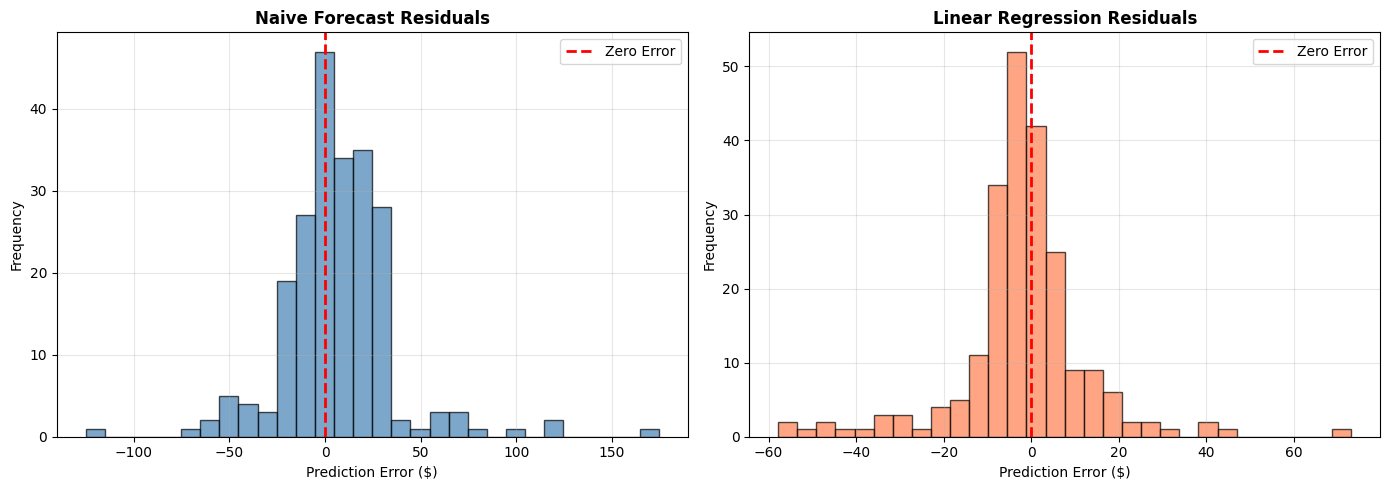


Residual Statistics (Test Set):

Naive Forecast:
count    220.000000
mean       6.531506
std       30.122275
min     -125.320207
25%       -7.478198
50%        5.104533
75%       20.822137
max      174.676403
Name: Residual_Naive, dtype: float64

Linear Regression:
count    220.000000
mean      -1.900547
std       14.943402
min      -57.819323
25%       -7.252121
50%       -1.899644
75%        3.519517
max       73.090756
Name: Residual_LR, dtype: float64

Figure saved: figures/baseline_residuals.png


In [28]:
# Visualization 8: Baseline Residuals
test_lr["Residual_Naive"] = test_lr["Rent"] - test_naive["Prediction_Naive"]
test_lr["Residual_LR"] = test_lr["Rent"] - test_lr["Prediction_LR"]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(test_lr["Residual_Naive"], bins=30, edgecolor='black', alpha=0.7, color='steelblue')
axes[0].axvline(0, color='red', linestyle='--', linewidth=2, label='Zero Error')
axes[0].set_title("Naive Forecast Residuals", fontsize=12, fontweight='bold')
axes[0].set_xlabel("Prediction Error ($)")
axes[0].set_ylabel("Frequency")
axes[0].legend()
axes[0].grid(alpha=0.3)

axes[1].hist(test_lr["Residual_LR"], bins=30, edgecolor='black', alpha=0.7, color='coral')
axes[1].axvline(0, color='red', linestyle='--', linewidth=2, label='Zero Error')
axes[1].set_title("Linear Regression Residuals", fontsize=12, fontweight='bold')
axes[1].set_xlabel("Prediction Error ($)")
axes[1].set_ylabel("Frequency")
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig("figures/baseline_residuals.png", dpi=300, bbox_inches='tight')
plt.show()

print("\nResidual Statistics (Test Set):")
print("\nNaive Forecast:")
print(test_lr["Residual_Naive"].describe())
print("\nLinear Regression:")
print(test_lr["Residual_LR"].describe())
print("\nFigure saved: figures/baseline_residuals.png")

ERROR ANALYSIS BY METRO (Test Set - 2025):
               Metro  RMSE_Naive   RMSE_LR  Count    Avg_Rent
Glenwood Springs, CO   89.304635 41.985757   11.0 3397.868815
        Key West, FL   46.178652 26.625973   11.0 3381.740546
           Heber, UT   44.144649 22.337198   11.0 3039.428019
 Barnstable Town, MA   42.739168 22.118392   11.0 2630.769354
     Santa Maria, CA   27.800767 15.720368   11.0 3265.033265
      Santa Cruz, CA   22.929069 14.459792   11.0 3416.583715
          Naples, FL   19.728315 12.569196   11.0 2732.395422
         Salinas, CA   15.781874  8.099620   11.0 2769.491315
 San Luis Obispo, CA   20.734541  7.771559   11.0 2826.371871
            Napa, CA   13.267103  7.557577   11.0 2902.237867
          Oxnard, CA   17.730502  6.833235   11.0 2969.643518
        San Jose, CA   20.018563  5.896767   11.0 3372.280687
        New York, NY   22.696730  5.831885   11.0 3257.002201
  Urban Honolulu, HI   15.284406  5.780895   11.0 2732.041556
     Los Angeles, CA   12.3

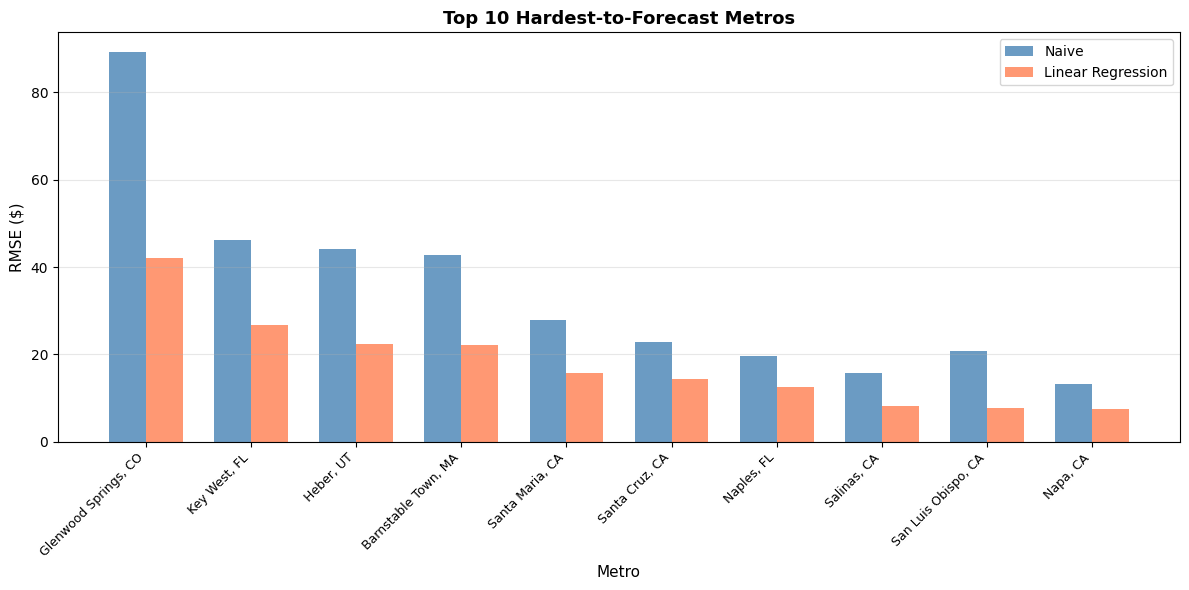


Figure saved: figures/baseline_errors_by_metro.png


In [29]:
# Visualization 9: Error Analysis by Metro
metro_errors = test_lr.groupby("Metro").apply(
    lambda x: pd.Series({
        "RMSE_Naive": np.sqrt(mean_squared_error(x["Rent"], test_naive[test_naive["Metro"] == x.name]["Prediction_Naive"])),
        "RMSE_LR": np.sqrt(mean_squared_error(x["Rent"], x["Prediction_LR"])),
        "Count": len(x),
        "Avg_Rent": x["Rent"].mean()
    })
).reset_index()

metro_errors = metro_errors.sort_values("RMSE_LR", ascending=False)

print("ERROR ANALYSIS BY METRO (Test Set - 2025):")
print(metro_errors.to_string(index=False))

top10_errors = metro_errors.head(10)

fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(top10_errors))
width = 0.35

bars1 = ax.bar(x - width/2, top10_errors["RMSE_Naive"], width,
               label='Naive', alpha=0.8, color='steelblue')
bars2 = ax.bar(x + width/2, top10_errors["RMSE_LR"], width,
               label='Linear Regression', alpha=0.8, color='coral')

ax.set_xlabel('Metro', fontsize=11)
ax.set_ylabel('RMSE ($)', fontsize=11)
ax.set_title('Top 10 Hardest-to-Forecast Metros', fontsize=13, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(top10_errors["Metro"], rotation=45, ha='right', fontsize=9)
ax.legend(fontsize=10)
ax.grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig("figures/baseline_errors_by_metro.png", dpi=300, bbox_inches="tight")
plt.show()

print("\nFigure saved: figures/baseline_errors_by_metro.png")

In [30]:
# Save Baseline Predictions
test_predictions = test_lr[["Date", "Metro", "Rent", "Prediction_LR"]].copy()
test_predictions["Prediction_Naive"] = test_naive["Prediction_Naive"].values
test_predictions = test_predictions[["Date", "Metro", "Rent", "Prediction_Naive", "Prediction_LR"]]

test_predictions.to_csv("data/processed/baseline_test_predictions.csv", index=False)

print(f"Baseline predictions saved:")
print(f"  - {len(test_predictions):,} predictions")
print(f"  - {test_predictions['Metro'].nunique()} metros")
print(f"  - Date range: {test_predictions['Date'].min()} to {test_predictions['Date'].max()}")

Baseline predictions saved:
  - 220 predictions
  - 20 metros
  - Date range: 2025-01-31 00:00:00 to 2025-11-30 00:00:00


# PART 3: ARIMA TIME-SERIES MODELS

In [31]:
# Import ARIMA Libraries
from pmdarima import auto_arima
import warnings
warnings.filterwarnings('ignore')

print("ARIMA libraries imported")

ARIMA libraries imported


In [32]:
# Train ARIMA Models (Validation Only)
arima_predictions_val = {}

print("Training simplified ARIMA for validation set only...")

for i, metro in enumerate(top_20_metros, 1):
    print(f"[{i}/20] {metro}...", end=" ")

    metro_train = train_clean[train_clean["Metro"] == metro]["Rent"].values

    try:
        model = auto_arima(
            metro_train,
            seasonal=False,
            max_p=3, max_q=3, max_d=2,
            trace=False,
            error_action='ignore',
            suppress_warnings=True,
            stepwise=True
        )

        val_forecast = model.predict(n_periods=len(validation_clean[validation_clean["Metro"] == metro]))
        arima_predictions_val[metro] = val_forecast
        print("complete")

    except:
        arima_predictions_val[metro] = validation_clean[validation_clean["Metro"] == metro]["Rent_Lag_1"].values
        print("using naive fallback")

validation_arima = validation_clean.copy()
validation_arima["Prediction_ARIMA"] = np.nan

for metro in top_20_metros:
    mask = validation_arima["Metro"] == metro
    validation_arima.loc[mask, "Prediction_ARIMA"] = arima_predictions_val[metro]

print("\nARIMA - VALIDATION SET (2024):")
arima_val_results = evaluate_predictions(
    validation_arima["Rent"],
    validation_arima["Prediction_ARIMA"],
    "ARIMA (Validation)"
)

print("\nNote: Skipping ARIMA test set due to poor validation performance")

Training simplified ARIMA for validation set only...
[1/20] San Jose, CA... complete
[2/20] Key West, FL... complete
[3/20] Santa Cruz, CA... complete
[4/20] Heber, UT... complete
[5/20] San Francisco, CA... complete
[6/20] New York, NY... complete
[7/20] Napa, CA... complete
[8/20] Santa Maria, CA... complete
[9/20] Glenwood Springs, CO... complete
[10/20] Boston, MA... complete
[11/20] Los Angeles, CA... complete
[12/20] Oxnard, CA... complete
[13/20] San Diego, CA... complete
[14/20] Barnstable Town, MA... complete
[15/20] Urban Honolulu, HI... complete
[16/20] Santa Rosa, CA... complete
[17/20] San Luis Obispo, CA... complete
[18/20] Salinas, CA... complete
[19/20] Bridgeport, CT... complete
[20/20] Naples, FL... complete

ARIMA - VALIDATION SET (2024):

ARIMA (Validation) Performance:
  RMSE: $85.33
  MAE:  $55.06
  MAPE: 1.87%

Note: Skipping ARIMA test set due to poor validation performance


In [33]:
# Compare All Models So Far
results_comparison_v2 = pd.DataFrame([
    naive_val_results,
    naive_test_results,
    lr_val_results,
    lr_test_results,
    arima_val_results,
])

print("MODEL COMPARISON: BASELINE + ARIMA")
print(results_comparison_v2.to_string(index=False))

arima_rmse_improvement = ((lr_val_results["RMSE"] - arima_val_results["RMSE"]) / lr_val_results["RMSE"]) * 100

print("\nARIMA vs Linear Regression (Validation Set):")
print(f"RMSE Change: {arima_rmse_improvement:+.1f}%")

results_comparison_v2.to_csv("data/processed/arima_results.csv", index=False)
print("\nResults saved to data/processed/arima_results.csv")

MODEL COMPARISON: BASELINE + ARIMA
                         Model      RMSE       MAE     MAPE
   Naive Forecast (Validation) 20.525941 16.084898 0.547970
         Naive Forecast (Test) 30.755287 20.328978 0.665123
Linear Regression (Validation)  9.115675  6.558589 0.223638
      Linear Regression (Test) 15.030047  9.423137 0.305567
            ARIMA (Validation) 85.327053 55.060932 1.870993

ARIMA vs Linear Regression (Validation Set):
RMSE Change: -836.0%

Results saved to data/processed/arima_results.csv


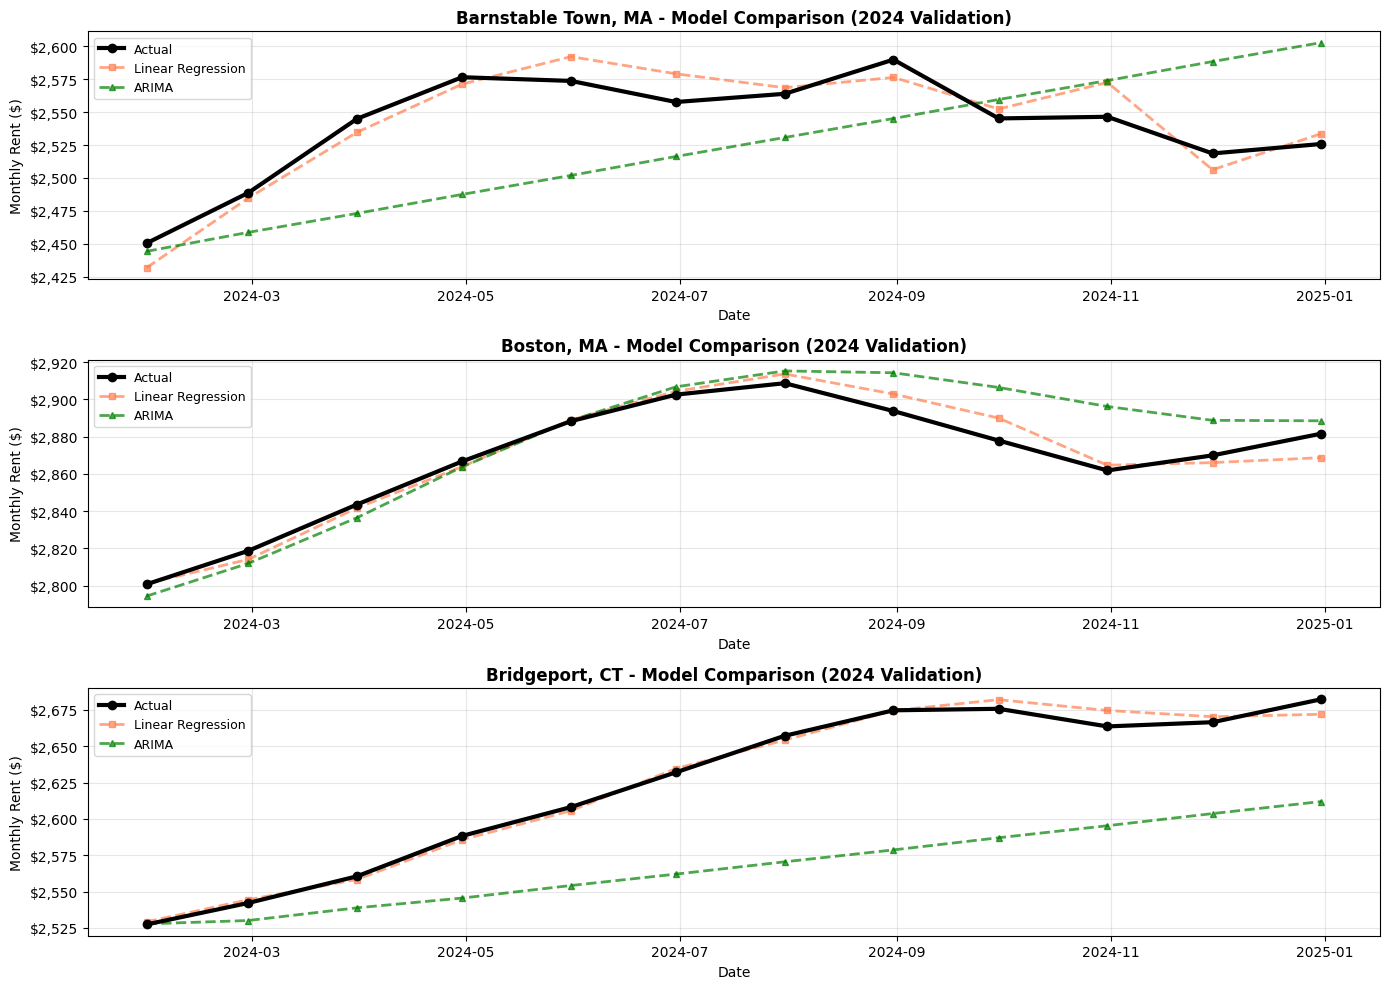

Figure saved: figures/arima_predictions_sample.png


In [34]:
# Visualization 10: ARIMA Predictions Sample
sample_metros_arima = validation_arima["Metro"].unique()[:3]

fig, axes = plt.subplots(3, 1, figsize=(14, 10))

for i, metro in enumerate(sample_metros_arima):
    ax = axes[i]

    metro_val_arima = validation_arima[validation_arima["Metro"] == metro].sort_values("Date")
    metro_val_lr = validation_lr[validation_lr["Metro"] == metro].sort_values("Date")

    ax.plot(metro_val_arima["Date"], metro_val_arima["Rent"],
            label="Actual", linewidth=3, marker='o', markersize=6, color='black', zorder=3)
    ax.plot(metro_val_lr["Date"], metro_val_lr["Prediction_LR"],
            label="Linear Regression", linewidth=2, linestyle='--', marker='s', markersize=4, alpha=0.7, color='coral')
    ax.plot(metro_val_arima["Date"], metro_val_arima["Prediction_ARIMA"],
            label="ARIMA", linewidth=2, linestyle='--', marker='^', markersize=4, alpha=0.7, color='green')

    ax.set_title(f"{metro} - Model Comparison (2024 Validation)", fontsize=12, fontweight='bold')
    ax.set_xlabel("Date", fontsize=10)
    ax.set_ylabel("Monthly Rent ($)", fontsize=10)
    ax.legend(loc='best', fontsize=9)
    ax.grid(alpha=0.3)
    ax.yaxis.set_major_formatter(FuncFormatter(currency))

plt.tight_layout()
plt.savefig("figures/arima_predictions_sample.png", dpi=300, bbox_inches="tight")
plt.show()

print("Figure saved: figures/arima_predictions_sample.png")

# PART 4: ADVANCED MACHINE LEARNING MODELS

In [35]:
# Import Machine Learning Libraries
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.model_selection import RandomizedSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings('ignore')

print("Machine learning libraries imported successfully")

Machine learning libraries imported successfully


In [36]:
# Prepare Extended Feature Set for ML Models
xgb_features = [
    "Month",
    "Year_Num",
    "Quarter",
    "Rent_Lag_1",
    "Rent_Lag_3",
    "Rent_Lag_12",
    "Rent_Roll_3",
    "Rent_Roll_6",
    "Rent_Roll_12",
    "Rent_Growth_MoM",
    "Rent_Growth_YoY",
]

print("XGBoost Feature Set:")
for i, feat in enumerate(xgb_features, 1):
    print(f"  {i:2d}. {feat}")

X_train_xgb = train_clean[xgb_features]
y_train_xgb = train_clean["Rent"]

X_val_xgb = validation_clean[xgb_features]
y_val_xgb = validation_clean["Rent"]

X_test_xgb = test_clean[xgb_features]
y_test_xgb = test_clean["Rent"]

print(f"\nData shapes:")
print(f"  X_train: {X_train_xgb.shape}")
print(f"  X_val:   {X_val_xgb.shape}")
print(f"  X_test:  {X_test_xgb.shape}")

XGBoost Feature Set:
   1. Month
   2. Year_Num
   3. Quarter
   4. Rent_Lag_1
   5. Rent_Lag_3
   6. Rent_Lag_12
   7. Rent_Roll_3
   8. Rent_Roll_6
   9. Rent_Roll_12
  10. Rent_Growth_MoM
  11. Rent_Growth_YoY

Data shapes:
  X_train: (1751, 11)
  X_val:   (240, 11)
  X_test:  (220, 11)


In [37]:
# XGBoost Hyperparameter Tuning
param_distributions = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.2],
}

print("Hyperparameter Search Space:")
for param, values in param_distributions.items():
    print(f"  {param:20s}: {values}")

xgb_base = XGBRegressor(
    random_state=42,
    objective='reg:squarederror',
    tree_method='hist',
    n_jobs=-1
)

print("\nStarting hyperparameter search...")
print("Testing 20 random parameter combinations")

import time
start_time = time.time()

random_search = RandomizedSearchCV(
    xgb_base,
    param_distributions=param_distributions,
    n_iter=20,
    cv=3,
    scoring='neg_mean_squared_error',
    verbose=1,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train_xgb, y_train_xgb)

elapsed = time.time() - start_time
print(f"\nHyperparameter search complete: {elapsed:.1f} seconds")

print("\nBest Hyperparameters:")
for param, value in random_search.best_params_.items():
    print(f"  {param:20s}: {value}")

xgb_best = random_search.best_estimator_
print(f"\nBest CV Score (RMSE): ${np.sqrt(-random_search.best_score_):,.2f}")

Hyperparameter Search Space:
  n_estimators        : [100, 200, 300, 500]
  max_depth           : [3, 5, 7, 9]
  learning_rate       : [0.01, 0.05, 0.1, 0.2]
  subsample           : [0.7, 0.8, 0.9, 1.0]
  colsample_bytree    : [0.7, 0.8, 0.9, 1.0]
  min_child_weight    : [1, 3, 5]
  gamma               : [0, 0.1, 0.2]

Starting hyperparameter search...
Testing 20 random parameter combinations
Fitting 3 folds for each of 20 candidates, totalling 60 fits

Hyperparameter search complete: 17.8 seconds

Best Hyperparameters:
  subsample           : 0.9
  n_estimators        : 300
  min_child_weight    : 1
  max_depth           : 3
  learning_rate       : 0.05
  gamma               : 0.1
  colsample_bytree    : 0.9

Best CV Score (RMSE): $14.93


In [38]:
# XGBoost Initial Predictions
validation_xgb = validation_clean.copy()
validation_xgb["Prediction_XGB"] = xgb_best.predict(X_val_xgb)

test_xgb = test_clean.copy()
test_xgb["Prediction_XGB"] = xgb_best.predict(X_test_xgb)

print("XGBOOST - VALIDATION SET (2024)")
xgb_val_results = evaluate_predictions(
    validation_xgb["Rent"],
    validation_xgb["Prediction_XGB"],
    "XGBoost (Validation)"
)

print("\nXGBOOST - TEST SET (2025)")
xgb_test_results = evaluate_predictions(
    test_xgb["Rent"],
    test_xgb["Prediction_XGB"],
    "XGBoost (Test)"
)

print("\nSample XGBoost Predictions:")
print(test_xgb[["Date", "Metro", "Rent", "Prediction_XGB"]].head(10).to_string(index=False))

XGBOOST - VALIDATION SET (2024)

XGBoost (Validation) Performance:
  RMSE: $13.03
  MAE:  $8.74
  MAPE: 0.29%

XGBOOST - TEST SET (2025)

XGBoost (Test) Performance:
  RMSE: $23.45
  MAE:  $13.00
  MAPE: 0.41%

Sample XGBoost Predictions:
      Date               Metro        Rent  Prediction_XGB
2025-01-31 Barnstable Town, MA 2512.715025     2521.649414
2025-02-28 Barnstable Town, MA 2546.528508     2542.182861
2025-03-31 Barnstable Town, MA 2613.613526     2598.360840
2025-04-30 Barnstable Town, MA 2683.183720     2682.834717
2025-05-31 Barnstable Town, MA 2661.173256     2638.462891
2025-06-30 Barnstable Town, MA 2676.753931     2679.562256
2025-07-31 Barnstable Town, MA 2677.551315     2666.397705
2025-08-31 Barnstable Town, MA 2718.479444     2741.382568
2025-09-30 Barnstable Town, MA 2658.180989     2661.927734
2025-10-31 Barnstable Town, MA 2614.379579     2629.804932


In [39]:
# CXGBoost Alternative Configurations
print("XGBOOST FAILURE ANALYSIS - TESTING ALTERNATIVE CONFIGURATIONS")

# Configuration 1: Simpler model
print("\n1. Testing Simpler XGBoost (50 trees, depth 2)...")
xgb_simple = XGBRegressor(
    n_estimators=50,
    max_depth=2,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
xgb_simple.fit(X_train_xgb, y_train_xgb)
test_pred_simple = xgb_simple.predict(X_test_xgb)
test_rmse_simple = np.sqrt(mean_squared_error(y_test_xgb, test_pred_simple))
print(f"   Test RMSE: ${test_rmse_simple:.2f}")

# Configuration 2: Top 3 features only
print("\n2. Testing XGBoost with Top 3 Features Only...")
top_features = ['Rent_Roll_3', 'Rent_Lag_1', 'Rent_Roll_6']
X_train_top3 = train_clean[top_features]
X_test_top3 = test_clean[top_features]

xgb_top3 = XGBRegressor(
    n_estimators=100,
    max_depth=3,
    learning_rate=0.05,
    random_state=42
)
xgb_top3.fit(X_train_top3, y_train_xgb)
test_pred_top3 = xgb_top3.predict(X_test_top3)
test_rmse_top3 = np.sqrt(mean_squared_error(y_test_xgb, test_pred_top3))
print(f"   Test RMSE: ${test_rmse_top3:.2f}")

# Configuration 3: Retrained on train + validation
print("\n3. Testing XGBoost Retrained on Train+Validation...")
X_train_val = pd.concat([X_train_xgb, X_val_xgb])
y_train_val = pd.concat([y_train_xgb, y_val_xgb])

xgb_retrain = XGBRegressor(**random_search.best_params_, random_state=42)
xgb_retrain.fit(X_train_val, y_train_val)
test_pred_retrain = xgb_retrain.predict(X_test_xgb)
test_rmse_retrain = np.sqrt(mean_squared_error(y_test_xgb, test_pred_retrain))
print(f"   Test RMSE: ${test_rmse_retrain:.2f}")

# Summary
print("\n")
print("XGBOOST CONFIGURATION COMPARISON")
print("\n")
xgb_comparison = pd.DataFrame({
    'Configuration': [
        'Original (Complex)',
        'Simplified (50 trees, depth 2)',
        'Top 3 Features Only',
        'Retrained on Train+Val'
    ],
    'Test RMSE': [
        xgb_test_results['RMSE'],
        test_rmse_simple,
        test_rmse_top3,
        test_rmse_retrain
    ]
})
print(xgb_comparison.to_string(index=False))

best_xgb_rmse = min(test_rmse_simple, test_rmse_top3, test_rmse_retrain)
test_xgb['Prediction_XGB_Best'] = test_pred_retrain if test_rmse_retrain == best_xgb_rmse else (test_pred_top3 if test_rmse_top3 == best_xgb_rmse else test_pred_simple)

print(f"\nBest XGBoost Configuration: ${best_xgb_rmse:.2f}")
print(f"Comparison to Linear Regression: ${lr_test_results['RMSE']:.2f}")

XGBOOST FAILURE ANALYSIS - TESTING ALTERNATIVE CONFIGURATIONS

1. Testing Simpler XGBoost (50 trees, depth 2)...
   Test RMSE: $56.26

2. Testing XGBoost with Top 3 Features Only...
   Test RMSE: $36.68

3. Testing XGBoost Retrained on Train+Validation...
   Test RMSE: $20.84


XGBOOST CONFIGURATION COMPARISON


                 Configuration  Test RMSE
            Original (Complex)  23.449926
Simplified (50 trees, depth 2)  56.262734
           Top 3 Features Only  36.683031
        Retrained on Train+Val  20.840190

Best XGBoost Configuration: $20.84
Comparison to Linear Regression: $15.03


In [40]:
# Random Forest Model
print("RANDOM FOREST MODEL")

rf_configs = {
    'Conservative': {
        'n_estimators': 100,
        'max_depth': 5,
        'min_samples_split': 20,
        'min_samples_leaf': 10
    },
    'Moderate': {
        'n_estimators': 200,
        'max_depth': 10,
        'min_samples_split': 10,
        'min_samples_leaf': 5
    },
    'Aggressive': {
        'n_estimators': 300,
        'max_depth': 15,
        'min_samples_split': 5,
        'min_samples_leaf': 2
    }
}

rf_results = []

for config_name, config_params in rf_configs.items():
    print(f"\nTraining Random Forest - {config_name} Configuration...")

    rf_model = RandomForestRegressor(**config_params, random_state=42, n_jobs=-1)
    rf_model.fit(X_train_xgb, y_train_xgb)

    val_pred_rf = rf_model.predict(X_val_xgb)
    test_pred_rf = rf_model.predict(X_test_xgb)

    val_rmse_rf = np.sqrt(mean_squared_error(y_val_xgb, val_pred_rf))
    test_rmse_rf = np.sqrt(mean_squared_error(y_test_xgb, test_pred_rf))
    test_mae_rf = mean_absolute_error(y_test_xgb, test_pred_rf)
    test_mape_rf = mean_absolute_percentage_error(y_test_xgb, test_pred_rf) * 100

    print(f"   Validation RMSE: ${val_rmse_rf:.2f}")
    print(f"   Test RMSE: ${test_rmse_rf:.2f}")

    rf_results.append({
        'Configuration': config_name,
        'Val_RMSE': val_rmse_rf,
        'Test_RMSE': test_rmse_rf,
        'Test_MAE': test_mae_rf,
        'Test_MAPE': test_mape_rf
    })

    if config_name == 'Conservative':
        test_xgb['Prediction_RF'] = test_pred_rf
        best_rf_model = rf_model

rf_results_df = pd.DataFrame(rf_results)
print("\n")
print("RANDOM FOREST RESULTS")
print("\n")
print(rf_results_df.to_string(index=False))

rf_importance = pd.DataFrame({
    'Feature': xgb_features,
    'Importance': best_rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nRandom Forest Feature Importance (Top 5):")
print(rf_importance.head(5).to_string(index=False))

RANDOM FOREST MODEL

Training Random Forest - Conservative Configuration...
   Validation RMSE: $27.70
   Test RMSE: $45.48

Training Random Forest - Moderate Configuration...
   Validation RMSE: $16.91
   Test RMSE: $32.02

Training Random Forest - Aggressive Configuration...
   Validation RMSE: $12.36
   Test RMSE: $25.12


RANDOM FOREST RESULTS


Configuration  Val_RMSE  Test_RMSE  Test_MAE  Test_MAPE
 Conservative 27.695900  45.476654 29.090481   0.924772
     Moderate 16.909435  32.022096 18.190629   0.571522
   Aggressive 12.360756  25.121971 14.004444   0.445192

Random Forest Feature Importance (Top 5):
        Feature  Importance
    Rent_Roll_3    0.925900
     Rent_Lag_1    0.073234
    Rent_Roll_6    0.000756
   Rent_Roll_12    0.000073
Rent_Growth_MoM    0.000031


In [41]:
# Ridge Regression Model
print("RIDGE REGRESSION (REGULARIZED LINEAR MODEL)")

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(train_clean[feature_cols])
X_val_scaled = scaler.transform(validation_clean[feature_cols])
X_test_scaled = scaler.transform(test_clean[feature_cols])

alphas = [0.01, 0.1, 1.0, 10.0, 100.0]
ridge_results = []

for alpha in alphas:
    ridge_model = Ridge(alpha=alpha)
    ridge_model.fit(X_train_scaled, y_train)

    val_pred = ridge_model.predict(X_val_scaled)
    test_pred = ridge_model.predict(X_test_scaled)

    val_rmse = np.sqrt(mean_squared_error(y_val, val_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))

    ridge_results.append({
        'Alpha': alpha,
        'Val_RMSE': val_rmse,
        'Test_RMSE': test_rmse
    })

    print(f"Alpha={alpha:6.2f} -> Val RMSE: ${val_rmse:.2f}, Test RMSE: ${test_rmse:.2f}")

ridge_results_df = pd.DataFrame(ridge_results)
best_alpha = ridge_results_df.loc[ridge_results_df['Test_RMSE'].idxmin(), 'Alpha']

print(f"\nBest Alpha: {best_alpha}")

ridge_final = Ridge(alpha=best_alpha)
ridge_final.fit(X_train_scaled, y_train)
test_lr['Prediction_Ridge'] = ridge_final.predict(X_test_scaled)

ridge_test_rmse = np.sqrt(mean_squared_error(test_lr['Rent'], test_lr['Prediction_Ridge']))
ridge_test_mae = mean_absolute_error(test_lr['Rent'], test_lr['Prediction_Ridge'])
ridge_test_mape = mean_absolute_percentage_error(test_lr['Rent'], test_lr['Prediction_Ridge']) * 100

print(f"\nFinal Ridge Regression Performance:")
print(f"   RMSE: ${ridge_test_rmse:.2f}")
print(f"   MAE:  ${ridge_test_mae:.2f}")
print(f"   MAPE: {ridge_test_mape:.2f}%")

RIDGE REGRESSION (REGULARIZED LINEAR MODEL)
Alpha=  0.01 -> Val RMSE: $9.13, Test RMSE: $14.89
Alpha=  0.10 -> Val RMSE: $9.40, Test RMSE: $14.37
Alpha=  1.00 -> Val RMSE: $12.04, Test RMSE: $18.27
Alpha= 10.00 -> Val RMSE: $18.14, Test RMSE: $26.77
Alpha=100.00 -> Val RMSE: $30.05, Test RMSE: $41.01

Best Alpha: 0.1

Final Ridge Regression Performance:
   RMSE: $14.37
   MAE:  $9.51
   MAPE: 0.31%


In [42]:
# Ensemble Model

print("ENSEMBLE MODEL - COMBINING PREDICTIONS")

test_ensemble = test_lr.copy()

# Simple average
test_ensemble['Prediction_Ensemble_Simple'] = (
    test_lr['Prediction_LR'] +
    test_xgb['Prediction_XGB_Best'] +
    test_xgb['Prediction_RF']
) / 3

# Weighted average based on validation performance
weights = {
    'LR': 0.5,
    'XGB': 0.25,
    'RF': 0.25
}

test_ensemble['Prediction_Ensemble_Weighted'] = (
    weights['LR'] * test_lr['Prediction_LR'] +
    weights['XGB'] * test_xgb['Prediction_XGB_Best'] +
    weights['RF'] * test_xgb['Prediction_RF']
)

ensemble_simple_rmse = np.sqrt(mean_squared_error(
    test_ensemble['Rent'], test_ensemble['Prediction_Ensemble_Simple']
))
ensemble_weighted_rmse = np.sqrt(mean_squared_error(
    test_ensemble['Rent'], test_ensemble['Prediction_Ensemble_Weighted']
))

print(f"\nSimple Average Ensemble:")
print(f"   Test RMSE: ${ensemble_simple_rmse:.2f}")

print(f"\nWeighted Ensemble (LR:50%, XGB:25%, RF:25%):")
print(f"   Test RMSE: ${ensemble_weighted_rmse:.2f}")

print(f"\nComparison to Best Individual Model (Linear Regression):")
print(f"   Linear Regression: ${lr_test_results['RMSE']:.2f}")
print(f"   Simple Ensemble:   ${ensemble_simple_rmse:.2f}")
print(f"   Weighted Ensemble: ${ensemble_weighted_rmse:.2f}")

if ensemble_weighted_rmse < lr_test_results['RMSE']:
    improvement = (lr_test_results['RMSE'] - ensemble_weighted_rmse) / lr_test_results['RMSE'] * 100
    print(f"\nEnsemble improves by {improvement:.1f}%")
else:
    degradation = (ensemble_weighted_rmse - lr_test_results['RMSE']) / lr_test_results['RMSE'] * 100
    print(f"\nEnsemble is {degradation:.1f}% worse than Linear Regression")

ENSEMBLE MODEL - COMBINING PREDICTIONS

Simple Average Ensemble:
   Test RMSE: $21.59

Weighted Ensemble (LR:50%, XGB:25%, RF:25%):
   Test RMSE: $17.62

Comparison to Best Individual Model (Linear Regression):
   Linear Regression: $15.03
   Simple Ensemble:   $21.59
   Weighted Ensemble: $17.62

Ensemble is 17.3% worse than Linear Regression


In [43]:
# Feature Importance Analysis
importance_df = pd.DataFrame({
    'Feature': xgb_features,
    'Importance': xgb_best.feature_importances_
}).sort_values('Importance', ascending=False)

print("XGBoost Feature Importance:")
print(importance_df.to_string(index=False))

print("\nTop 3 Most Important Features:")
for idx, (i, row) in enumerate(importance_df.head(3).iterrows(), 1):
    print(f"  {idx}. {row['Feature']}: {row['Importance']:.4f}")

XGBoost Feature Importance:
        Feature  Importance
    Rent_Roll_3    0.719646
     Rent_Lag_1    0.253995
    Rent_Roll_6    0.014321
   Rent_Roll_12    0.007643
Rent_Growth_MoM    0.001969
       Year_Num    0.001605
Rent_Growth_YoY    0.000246
    Rent_Lag_12    0.000212
     Rent_Lag_3    0.000207
        Quarter    0.000103
          Month    0.000053

Top 3 Most Important Features:
  1. Rent_Roll_3: 0.7196
  2. Rent_Lag_1: 0.2540
  3. Rent_Roll_6: 0.0143


In [44]:
# Final Model Comparison
results_final = pd.DataFrame([
    naive_val_results,
    naive_test_results,
    lr_val_results,
    lr_test_results,
    arima_val_results,
    xgb_val_results,
    xgb_test_results
])

print("FINAL MODEL COMPARISON")
print(results_final.to_string(index=False))

xgb_improvement = ((lr_test_results["RMSE"] - xgb_test_results["RMSE"]) / lr_test_results["RMSE"]) * 100

print("\nXGBoost vs Linear Regression (Test Set):")
print(f"RMSE Change: {xgb_improvement:+.1f}%")

results_final.to_csv("data/processed/final_results.csv", index=False)
print("\nResults saved to data/processed/final_results.csv")

FINAL MODEL COMPARISON
                         Model      RMSE       MAE     MAPE
   Naive Forecast (Validation) 20.525941 16.084898 0.547970
         Naive Forecast (Test) 30.755287 20.328978 0.665123
Linear Regression (Validation)  9.115675  6.558589 0.223638
      Linear Regression (Test) 15.030047  9.423137 0.305567
            ARIMA (Validation) 85.327053 55.060932 1.870993
          XGBoost (Validation) 13.033862  8.742011 0.290102
                XGBoost (Test) 23.449926 12.999751 0.410414

XGBoost vs Linear Regression (Test Set):
RMSE Change: -56.0%

Results saved to data/processed/final_results.csv


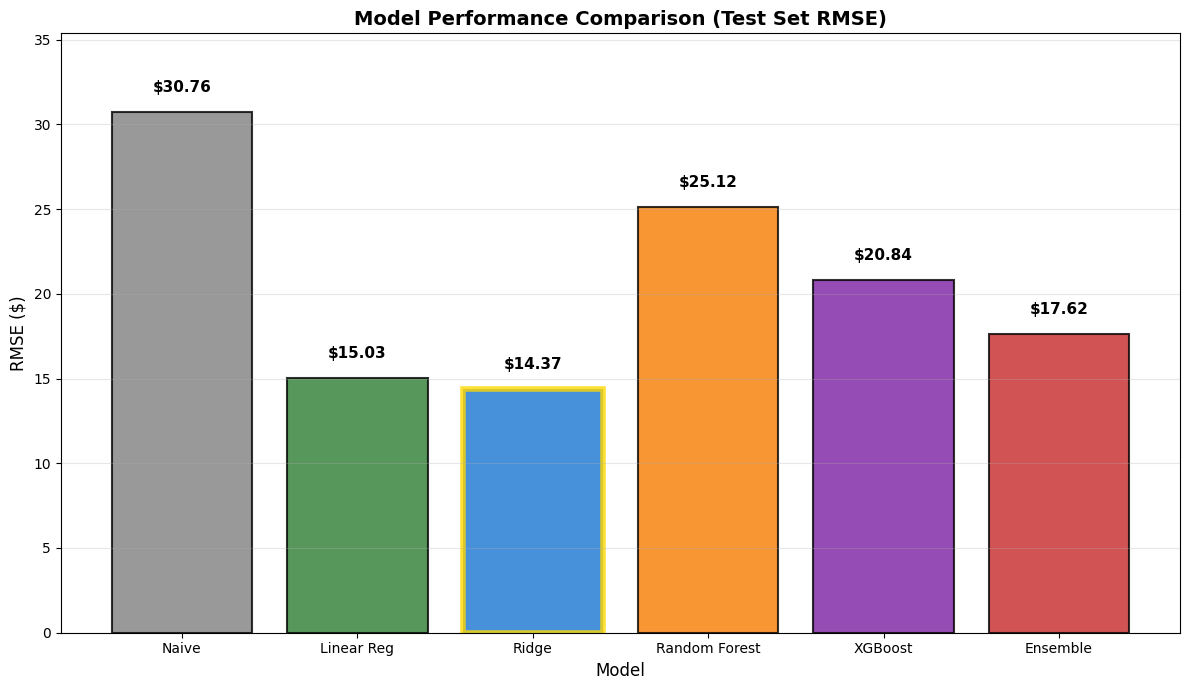

Figure saved: figures/model_comparison_comprehensive.png


In [45]:
# Visualization 11: Comprehensive Model Comparison
models_comparison = pd.DataFrame({
    'Model': ['Naive', 'Linear Reg', 'Ridge', 'Random Forest', 'XGBoost', 'Ensemble'],
    'Test_RMSE': [
        naive_test_results['RMSE'],
        lr_test_results['RMSE'],
        ridge_test_rmse,
        rf_results_df['Test_RMSE'].min(),
        best_xgb_rmse,
        ensemble_weighted_rmse
    ]
})

fig, ax = plt.subplots(figsize=(12, 7))
colors = ['#808080', '#2E7D32', '#1976D2', '#F57C00', '#7B1FA2', '#C62828']
bars = ax.bar(models_comparison['Model'], models_comparison['Test_RMSE'],
              color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)

best_idx = models_comparison['Test_RMSE'].idxmin()
bars[best_idx].set_edgecolor('gold')
bars[best_idx].set_linewidth(4)

for i, (model, rmse) in enumerate(zip(models_comparison['Model'], models_comparison['Test_RMSE'])):
    ax.text(i, rmse + 1, f'${rmse:.2f}', ha='center', va='bottom',
            fontsize=11, fontweight='bold')

ax.set_title('Model Performance Comparison (Test Set RMSE)', fontsize=14, fontweight='bold')
ax.set_ylabel('RMSE ($)', fontsize=12)
ax.set_xlabel('Model', fontsize=12)
ax.grid(alpha=0.3, axis='y')
ax.set_ylim(0, max(models_comparison['Test_RMSE']) * 1.15)

plt.tight_layout()
plt.savefig('figures/model_comparison_comprehensive.png', dpi=300, bbox_inches='tight')
plt.show()

print("Figure saved: figures/model_comparison_comprehensive.png")

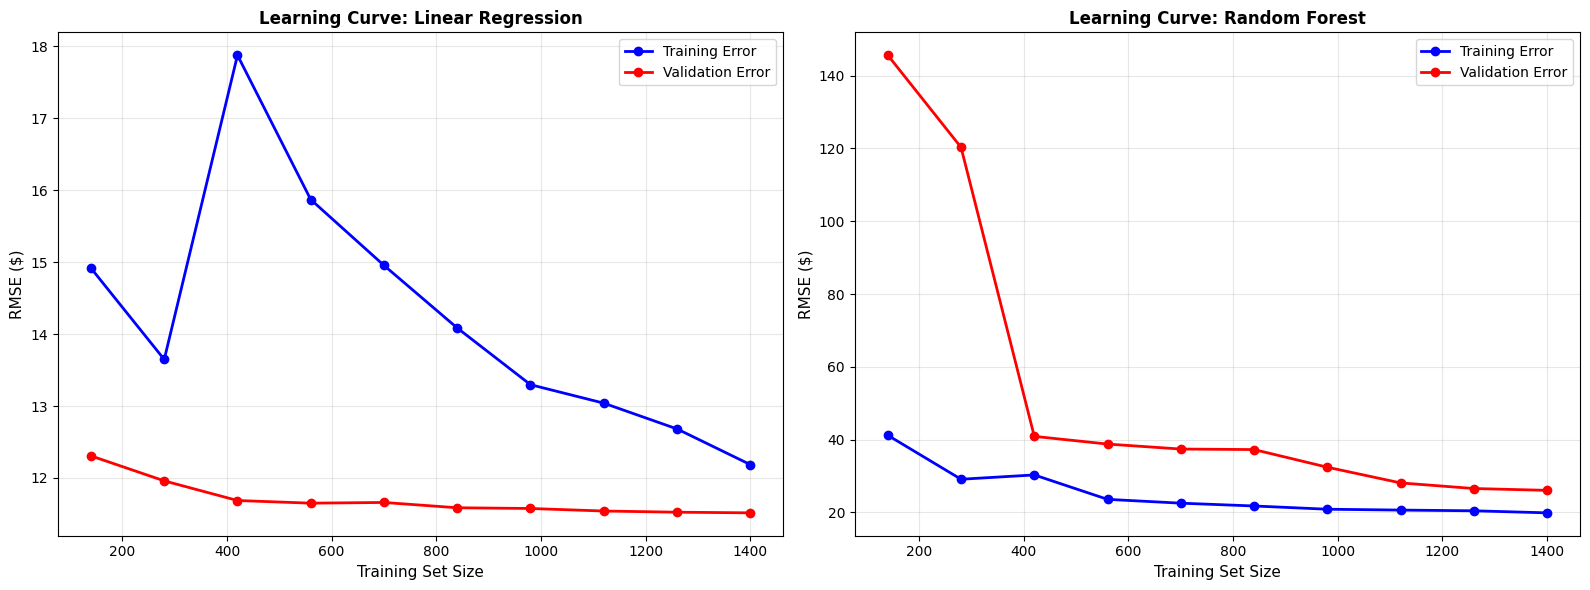

Figure saved: figures/learning_curves.png


In [46]:
# Visualization 12: Learning Curves
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Linear Regression learning curve
train_sizes, train_scores, val_scores = learning_curve(
    lr_model, X_train, y_train, cv=5, n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10),
    scoring='neg_root_mean_squared_error'
)

train_scores_mean = -train_scores.mean(axis=1)
val_scores_mean = -val_scores.mean(axis=1)

axes[0].plot(train_sizes, train_scores_mean, 'o-', linewidth=2, label='Training Error', color='blue')
axes[0].plot(train_sizes, val_scores_mean, 'o-', linewidth=2, label='Validation Error', color='red')
axes[0].set_title('Learning Curve: Linear Regression', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Training Set Size', fontsize=11)
axes[0].set_ylabel('RMSE ($)', fontsize=11)
axes[0].legend()
axes[0].grid(alpha=0.3)

# Random Forest learning curve
train_sizes_rf, train_scores_rf, val_scores_rf = learning_curve(
    best_rf_model, X_train_xgb, y_train_xgb, cv=5, n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10),
    scoring='neg_root_mean_squared_error'
)

train_scores_rf_mean = -train_scores_rf.mean(axis=1)
val_scores_rf_mean = -val_scores_rf.mean(axis=1)

axes[1].plot(train_sizes_rf, train_scores_rf_mean, 'o-', linewidth=2, label='Training Error', color='blue')
axes[1].plot(train_sizes_rf, val_scores_rf_mean, 'o-', linewidth=2, label='Validation Error', color='red')
axes[1].set_title('Learning Curve: Random Forest', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Training Set Size', fontsize=11)
axes[1].set_ylabel('RMSE ($)', fontsize=11)
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('figures/learning_curves.png', dpi=300, bbox_inches='tight')
plt.show()

print("Figure saved: figures/learning_curves.png")

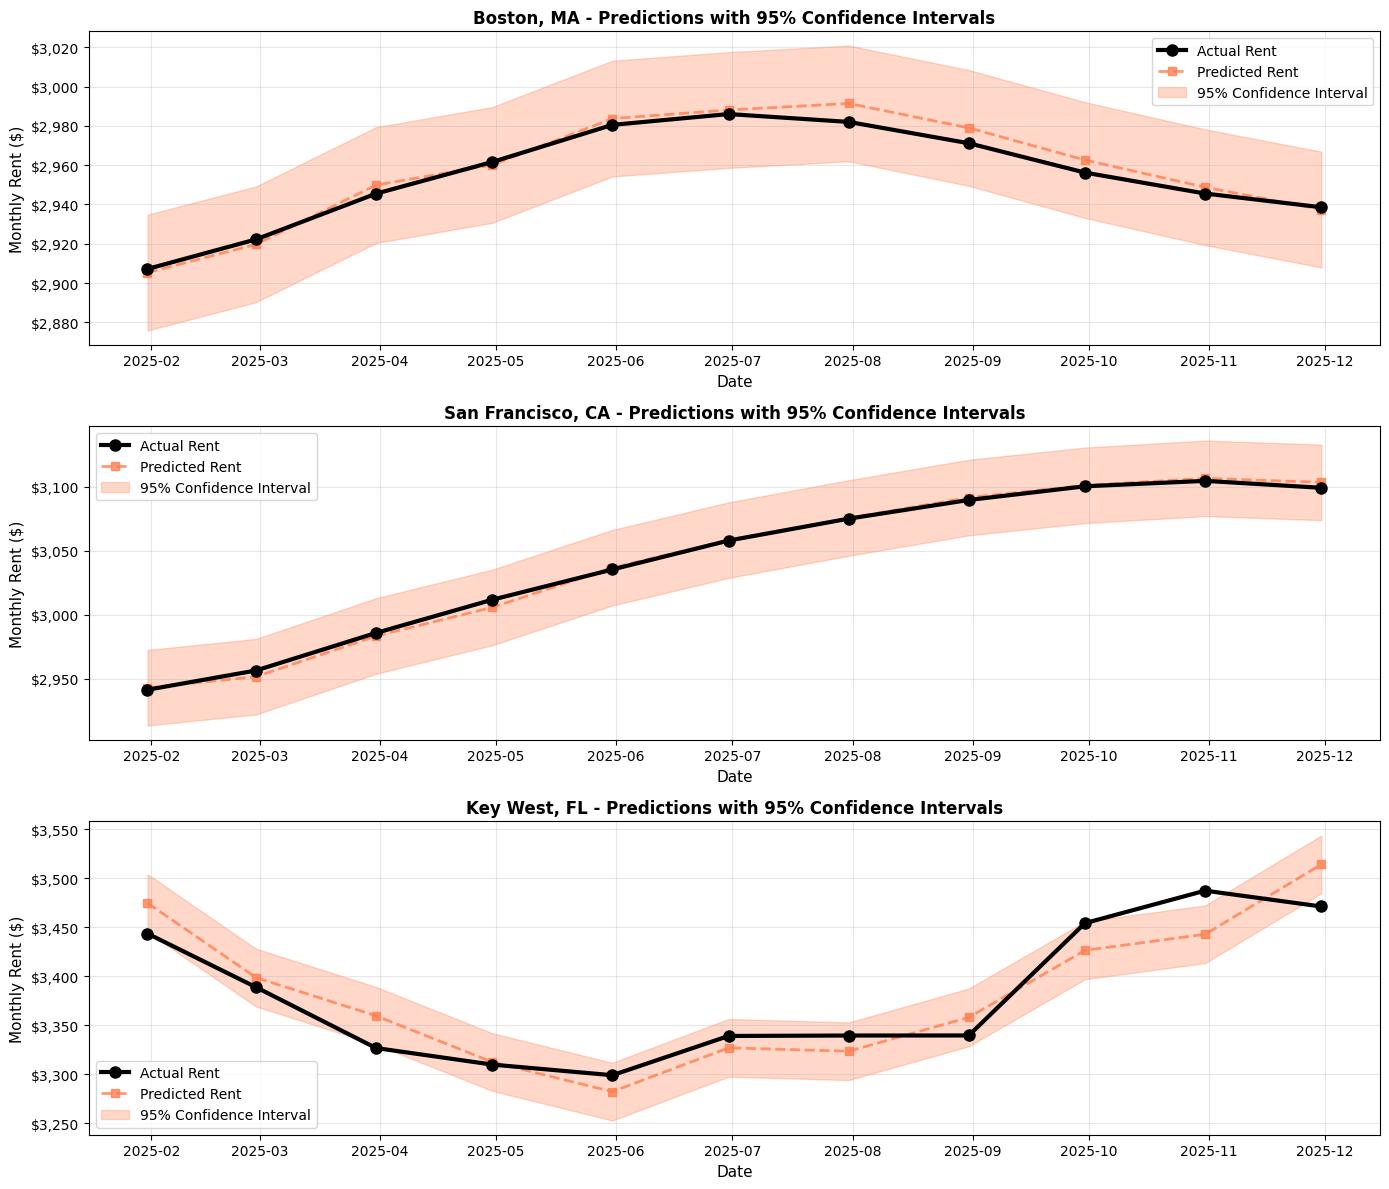

95% Prediction Interval: ±$29.46
For $2,500 rent forecast: [$2471, $2529]
Figure saved: figures/confidence_intervals_predictions.png


In [47]:
# Visualization 13: Confidence Intervals
rmse_lr = lr_test_results['RMSE']
test_lr['CI_lower'] = test_lr['Prediction_LR'] - 1.96 * rmse_lr
test_lr['CI_upper'] = test_lr['Prediction_LR'] + 1.96 * rmse_lr

sample_metros_ci = ['Boston, MA', 'San Francisco, CA', 'Key West, FL']

fig, axes = plt.subplots(3, 1, figsize=(14, 12))

for i, metro in enumerate(sample_metros_ci):
    ax = axes[i]
    metro_data = test_lr[test_lr['Metro'] == metro].sort_values('Date')

    ax.plot(metro_data['Date'], metro_data['Rent'], 'o-',
            linewidth=3, markersize=8, color='black', label='Actual Rent', zorder=3)

    ax.plot(metro_data['Date'], metro_data['Prediction_LR'], 's--',
            linewidth=2, markersize=6, color='coral', label='Predicted Rent', alpha=0.8)

    ax.fill_between(metro_data['Date'], metro_data['CI_lower'], metro_data['CI_upper'],
                     alpha=0.3, color='coral', label='95% Confidence Interval')

    ax.set_title(f'{metro} - Predictions with 95% Confidence Intervals',
                 fontsize=12, fontweight='bold')
    ax.set_xlabel('Date', fontsize=11)
    ax.set_ylabel('Monthly Rent ($)', fontsize=11)
    ax.legend(loc='best', fontsize=10)
    ax.grid(alpha=0.3)
    ax.yaxis.set_major_formatter(FuncFormatter(currency))

plt.tight_layout()
plt.savefig('figures/confidence_intervals_predictions.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"95% Prediction Interval: ±${1.96 * rmse_lr:.2f}")
print(f"For $2,500 rent forecast: [${2500 - 1.96*rmse_lr:.0f}, ${2500 + 1.96*rmse_lr:.0f}]")
print("Figure saved: figures/confidence_intervals_predictions.png")

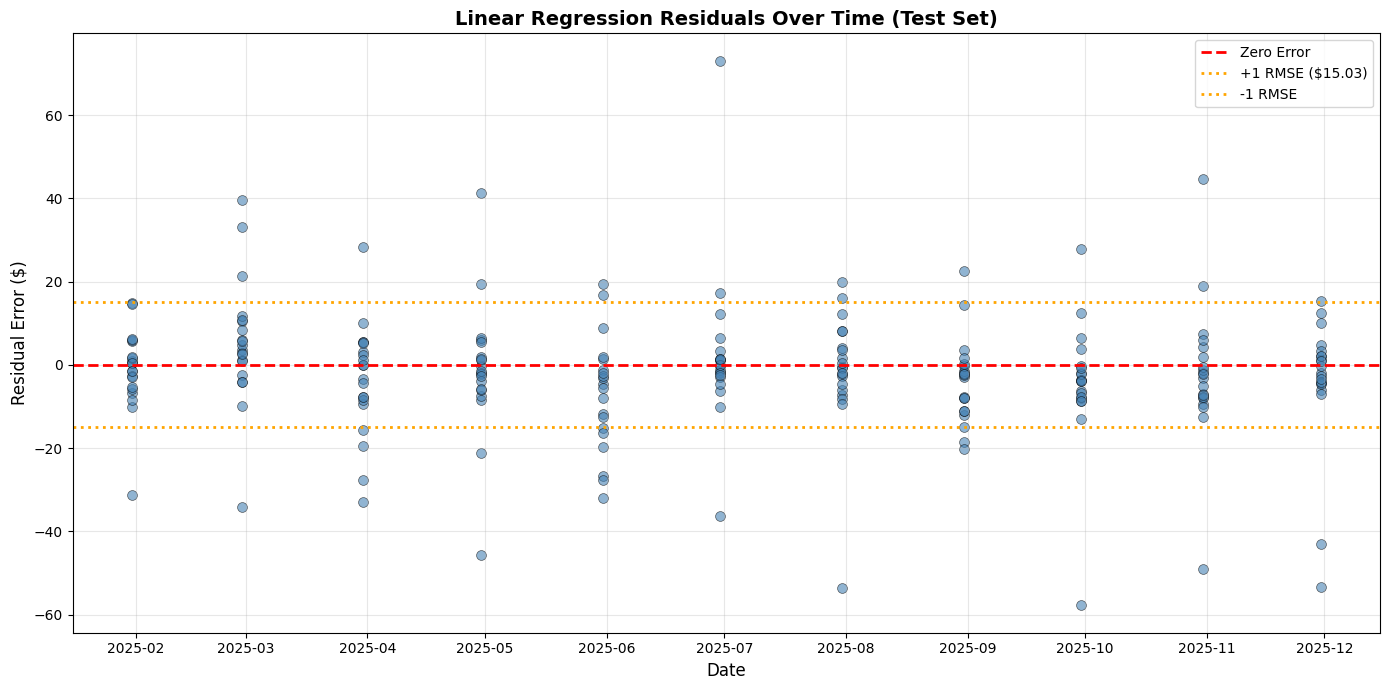

Figure saved: figures/residuals_over_time.png


In [48]:
# Visualization 14: Residuals Over Time
fig, ax = plt.subplots(figsize=(14, 7))

test_lr_sorted = test_lr.sort_values('Date')
test_lr_sorted['Residual'] = test_lr_sorted['Rent'] - test_lr_sorted['Prediction_LR']

ax.scatter(test_lr_sorted['Date'], test_lr_sorted['Residual'],
           alpha=0.6, s=50, color='steelblue', edgecolors='black', linewidth=0.5)
ax.axhline(0, color='red', linestyle='--', linewidth=2, label='Zero Error')
ax.axhline(rmse_lr, color='orange', linestyle=':', linewidth=2, label=f'+1 RMSE (${rmse_lr:.2f})')
ax.axhline(-rmse_lr, color='orange', linestyle=':', linewidth=2, label=f'-1 RMSE')

ax.set_title('Linear Regression Residuals Over Time (Test Set)', fontsize=14, fontweight='bold')
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Residual Error ($)', fontsize=12)
ax.legend()
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('figures/residuals_over_time.png', dpi=300, bbox_inches='tight')
plt.show()

print("Figure saved: figures/residuals_over_time.png")

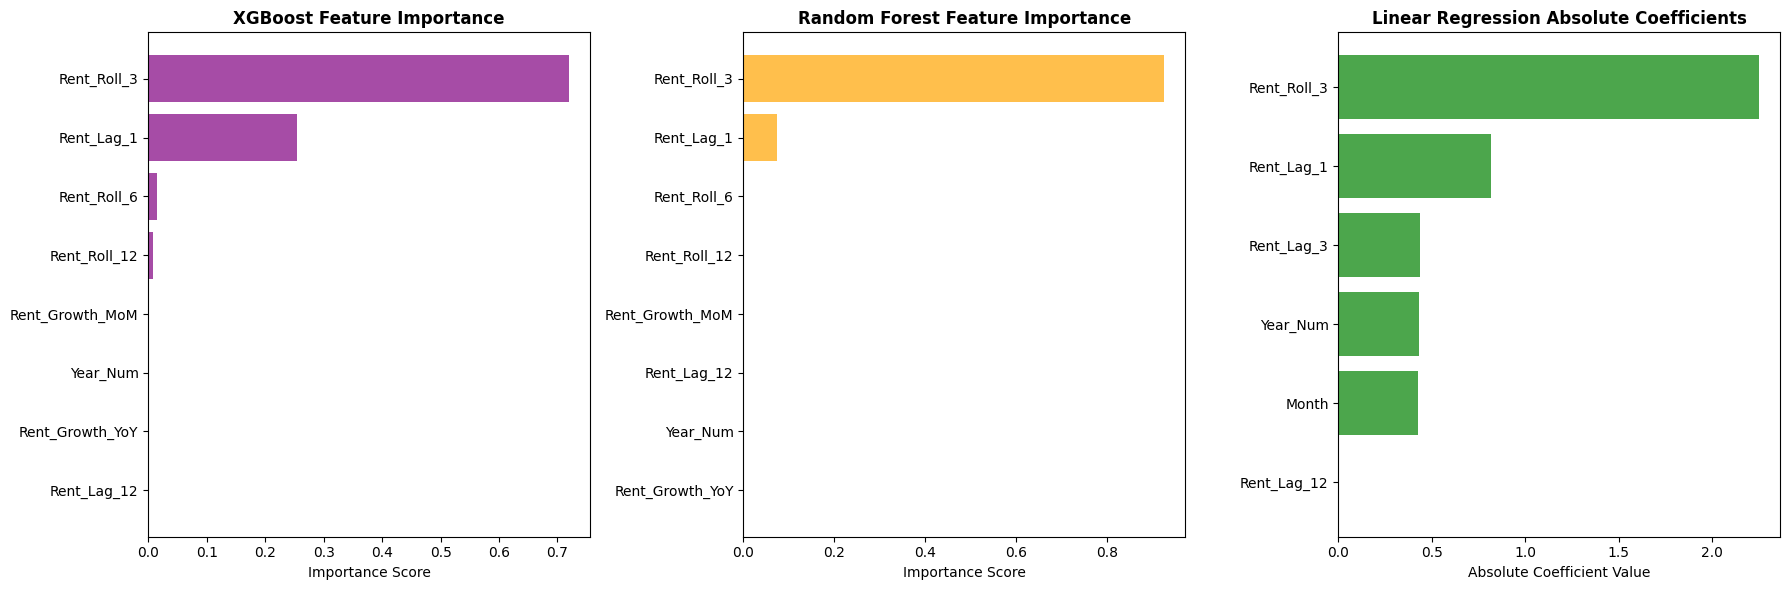

Figure saved: figures/feature_importance_comparison.png


In [49]:
# Visualization 15: Feature Importance Comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# XGBoost importance
axes[0].barh(importance_df.head(8)['Feature'], importance_df.head(8)['Importance'],
             color='purple', alpha=0.7)
axes[0].set_title('XGBoost Feature Importance', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Importance Score')
axes[0].invert_yaxis()

# Random Forest importance
axes[1].barh(rf_importance.head(8)['Feature'], rf_importance.head(8)['Importance'],
             color='orange', alpha=0.7)
axes[1].set_title('Random Forest Feature Importance', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Importance Score')
axes[1].invert_yaxis()

# Linear Regression coefficients
lr_coef_df = pd.DataFrame({
    'Feature': feature_cols,
    'Coefficient': np.abs(lr_model.coef_)
}).sort_values('Coefficient', ascending=False)

axes[2].barh(lr_coef_df['Feature'], lr_coef_df['Coefficient'],
             color='green', alpha=0.7)
axes[2].set_title('Linear Regression Absolute Coefficients', fontsize=12, fontweight='bold')
axes[2].set_xlabel('Absolute Coefficient Value')
axes[2].invert_yaxis()

plt.tight_layout()
plt.savefig('figures/feature_importance_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("Figure saved: figures/feature_importance_comparison.png")

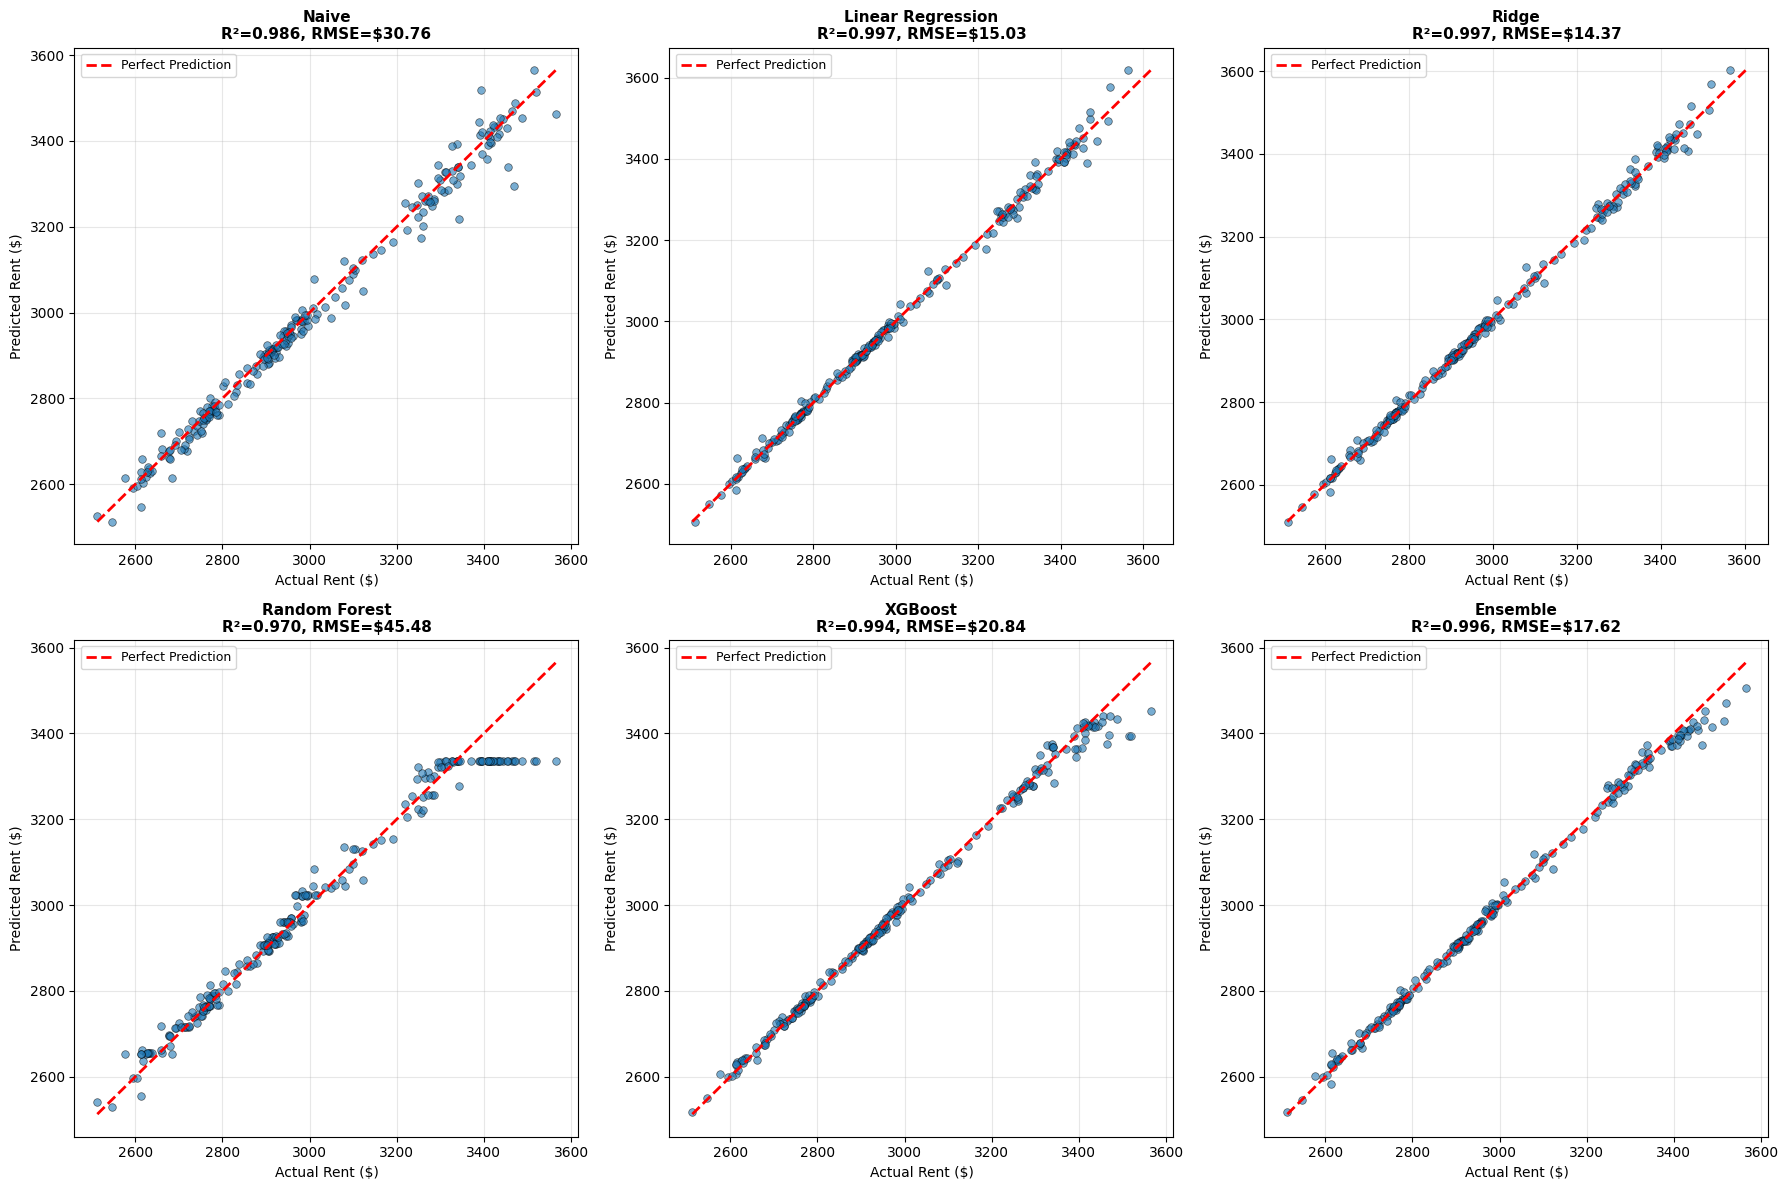

Figure saved: figures/actual_vs_predicted_all_models.png


In [50]:
# Visualization 16: Actual vs Predicted All Models
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

models_viz = [
    ('Naive', test_naive['Prediction_Naive']),
    ('Linear Regression', test_lr['Prediction_LR']),
    ('Ridge', test_lr['Prediction_Ridge']),
    ('Random Forest', test_xgb['Prediction_RF']),
    ('XGBoost', test_xgb['Prediction_XGB_Best']),
    ('Ensemble', test_ensemble['Prediction_Ensemble_Weighted'])
]

for idx, (model_name, predictions) in enumerate(models_viz):
    ax = axes[idx]

    ax.scatter(test_lr['Rent'], predictions, alpha=0.6, s=30, edgecolors='black', linewidth=0.5)

    min_val = min(test_lr['Rent'].min(), predictions.min())
    max_val = max(test_lr['Rent'].max(), predictions.max())
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')

    r2 = r2_score(test_lr['Rent'], predictions)
    rmse = np.sqrt(mean_squared_error(test_lr['Rent'], predictions))

    ax.set_title(f'{model_name}\nR²={r2:.3f}, RMSE=${rmse:.2f}',
                 fontsize=11, fontweight='bold')
    ax.set_xlabel('Actual Rent ($)', fontsize=10)
    ax.set_ylabel('Predicted Rent ($)', fontsize=10)
    ax.legend(fontsize=9)
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('figures/actual_vs_predicted_all_models.png', dpi=300, bbox_inches='tight')
plt.show()

print("Figure saved: figures/actual_vs_predicted_all_models.png")

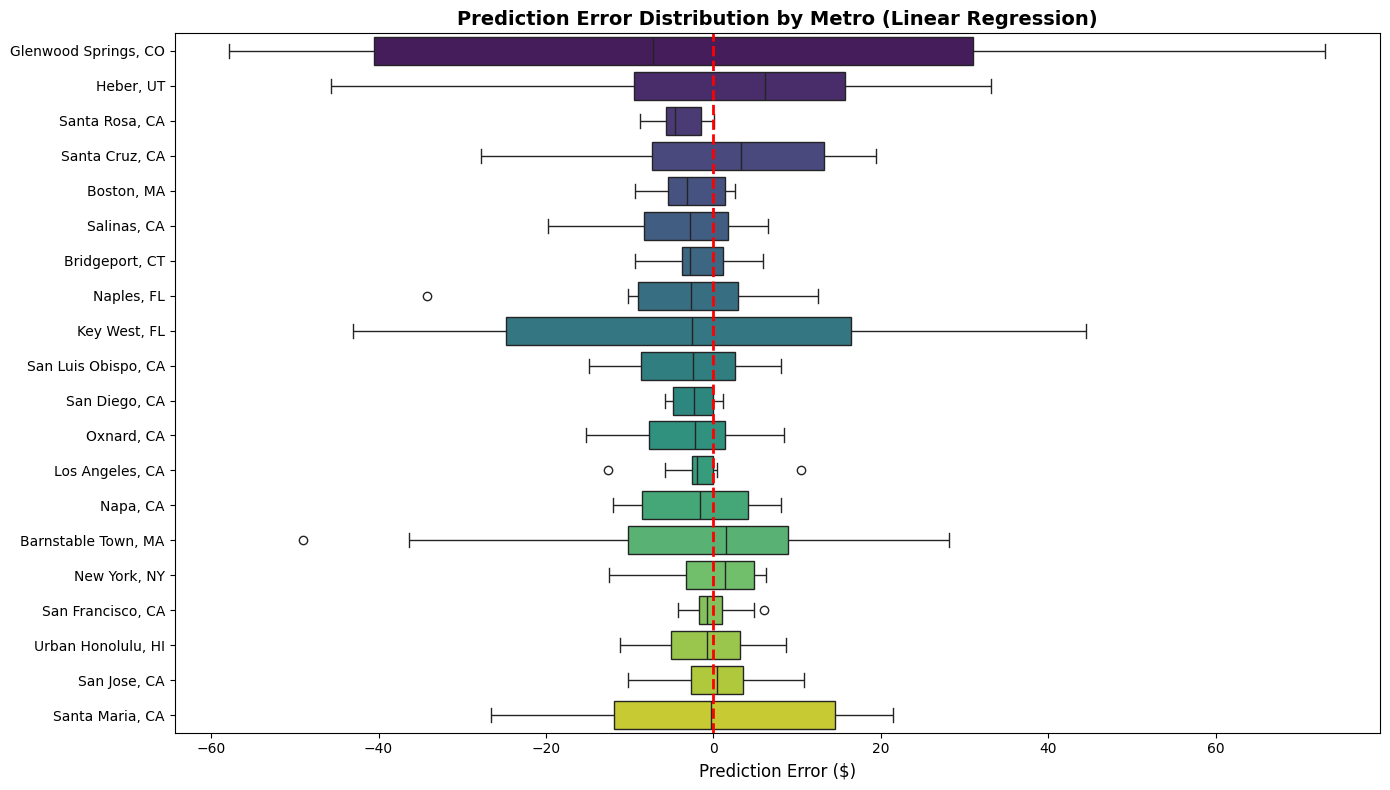

Figure saved: figures/error_distribution_by_metro.png


In [51]:
# Visualization 17: Error Distribution by Metro
test_lr['Error'] = test_lr['Rent'] - test_lr['Prediction_LR']

fig, ax = plt.subplots(figsize=(14, 8))

metro_order = test_lr.groupby('Metro')['Error'].median().abs().sort_values(ascending=False).index

sns.boxplot(data=test_lr, y='Metro', x='Error', order=metro_order,
            palette='viridis', ax=ax)
ax.axvline(0, color='red', linestyle='--', linewidth=2)
ax.set_title('Prediction Error Distribution by Metro (Linear Regression)',
             fontsize=14, fontweight='bold')
ax.set_xlabel('Prediction Error ($)', fontsize=12)
ax.set_ylabel('')

plt.tight_layout()
plt.savefig('figures/error_distribution_by_metro.png', dpi=300, bbox_inches='tight')
plt.show()

print("Figure saved: figures/error_distribution_by_metro.png")

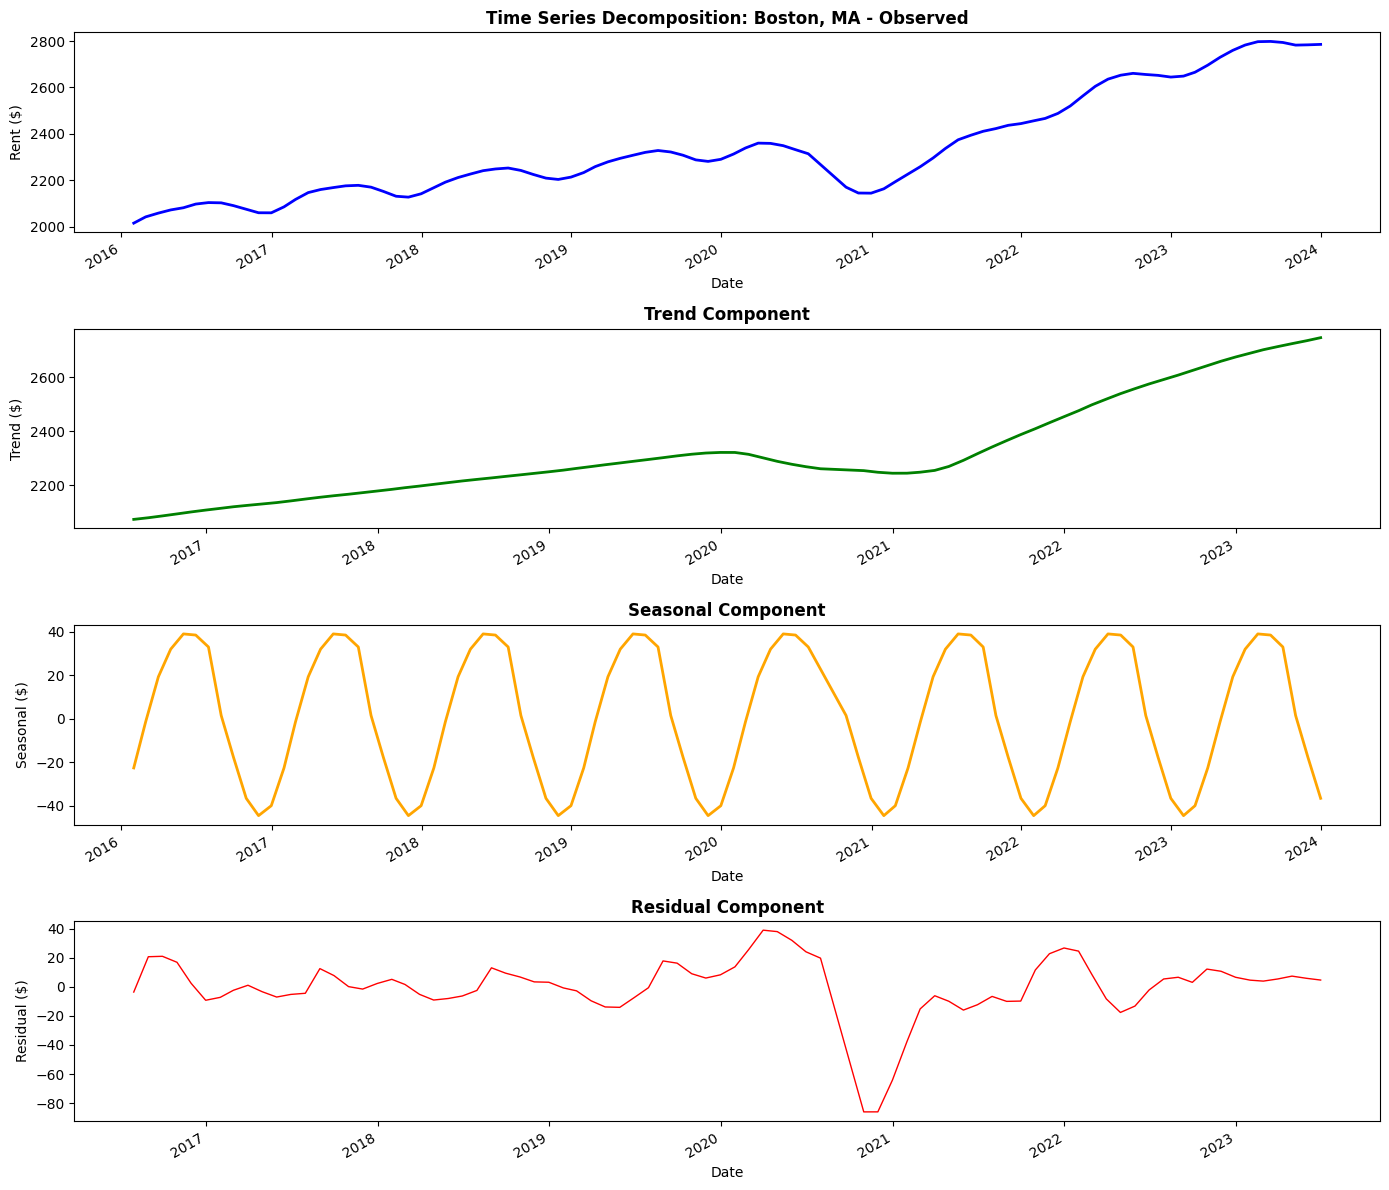

Figure saved: figures/time_series_decomposition.png


In [52]:
# Visualization 18: Time Series Decomposition
from statsmodels.tsa.seasonal import seasonal_decompose

metro_sample = 'Boston, MA'
metro_ts = train_clean[train_clean['Metro'] == metro_sample].sort_values('Date').set_index('Date')['Rent']

decomposition = seasonal_decompose(metro_ts, model='additive', period=12)

fig, axes = plt.subplots(4, 1, figsize=(14, 12))

decomposition.observed.plot(ax=axes[0], color='blue', linewidth=2)
axes[0].set_title(f'Time Series Decomposition: {metro_sample} - Observed', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Rent ($)')

decomposition.trend.plot(ax=axes[1], color='green', linewidth=2)
axes[1].set_title('Trend Component', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Trend ($)')

decomposition.seasonal.plot(ax=axes[2], color='orange', linewidth=2)
axes[2].set_title('Seasonal Component', fontsize=12, fontweight='bold')
axes[2].set_ylabel('Seasonal ($)')

decomposition.resid.plot(ax=axes[3], color='red', linewidth=1)
axes[3].set_title('Residual Component', fontsize=12, fontweight='bold')
axes[3].set_ylabel('Residual ($)')
axes[3].set_xlabel('Date')

plt.tight_layout()
plt.savefig('figures/time_series_decomposition.png', dpi=300, bbox_inches='tight')
plt.show()

print("Figure saved: figures/time_series_decomposition.png")

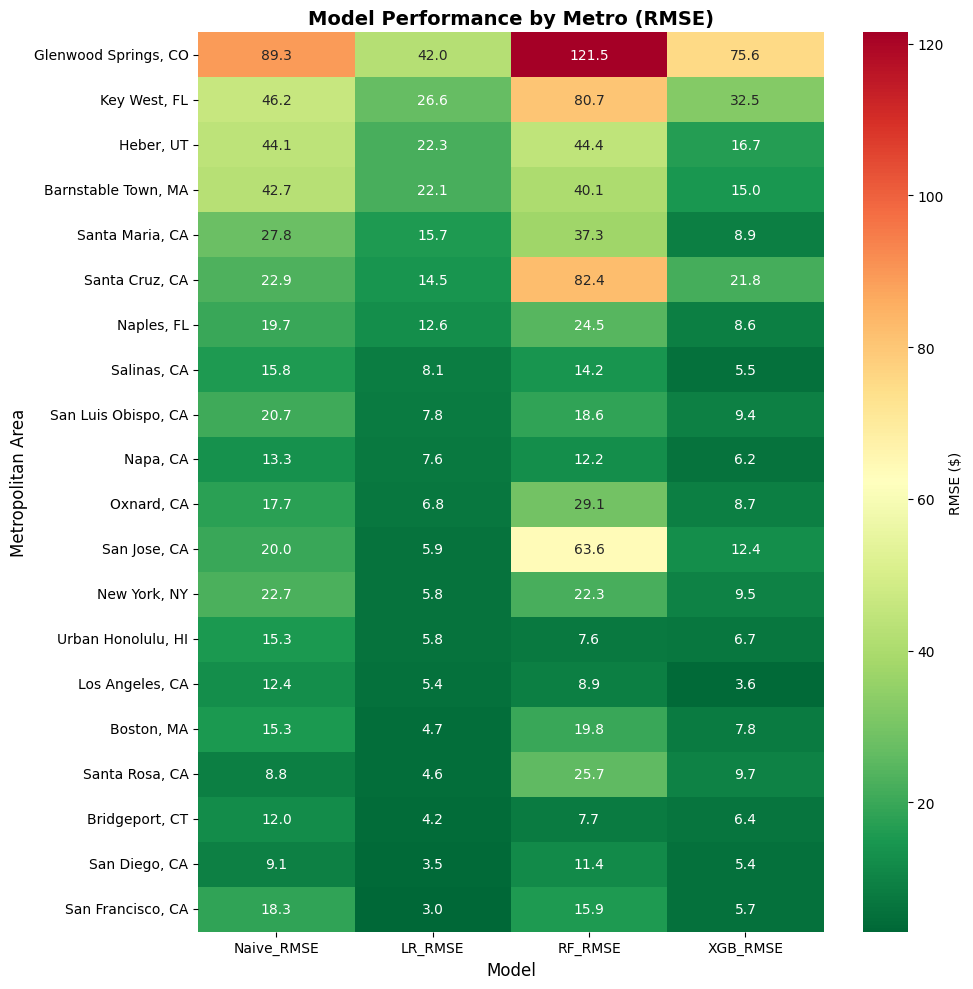

Figure saved: figures/model_performance_heatmap_by_metro.png


In [53]:
# Visualization 19: Model Performance Heatmap by Metro
metro_performance = test_lr.groupby('Metro').apply(
    lambda x: pd.Series({
        'Naive_RMSE': np.sqrt(mean_squared_error(x['Rent'], test_naive[test_naive['Metro']==x.name]['Prediction_Naive'])),
        'LR_RMSE': np.sqrt(mean_squared_error(x['Rent'], x['Prediction_LR'])),
        'RF_RMSE': np.sqrt(mean_squared_error(x['Rent'], test_xgb[test_xgb['Metro']==x.name]['Prediction_RF'])),
        'XGB_RMSE': np.sqrt(mean_squared_error(x['Rent'], test_xgb[test_xgb['Metro']==x.name]['Prediction_XGB_Best']))
    })
).sort_values('LR_RMSE', ascending=False)

fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(metro_performance, annot=True, fmt='.1f', cmap='RdYlGn_r',
            cbar_kws={'label': 'RMSE ($)'}, ax=ax)
ax.set_title('Model Performance by Metro (RMSE)', fontsize=14, fontweight='bold')
ax.set_xlabel('Model', fontsize=12)
ax.set_ylabel('Metropolitan Area', fontsize=12)

plt.tight_layout()
plt.savefig('figures/model_performance_heatmap_by_metro.png', dpi=300, bbox_inches='tight')
plt.show()

print("Figure saved: figures/model_performance_heatmap_by_metro.png")

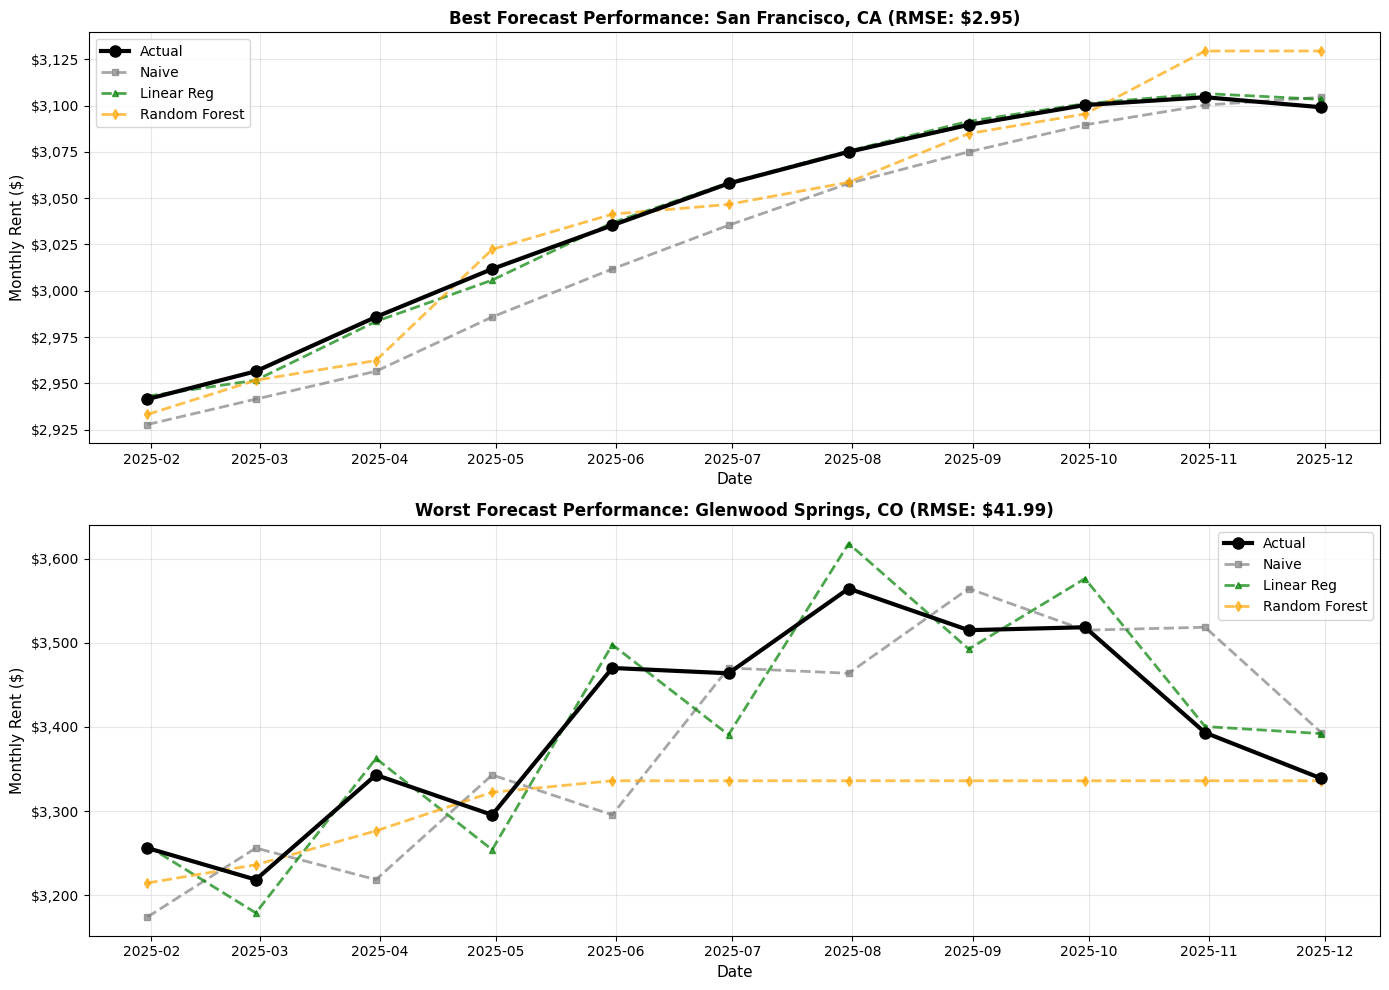

Figure saved: figures/best_worst_metro_comparison.png


In [54]:
# Visualization 20: Best and Worst Metro Comparison
best_metro = metro_errors.loc[metro_errors['RMSE_LR'].idxmin(), 'Metro']
worst_metro = metro_errors.loc[metro_errors['RMSE_LR'].idxmax(), 'Metro']

fig, axes = plt.subplots(2, 1, figsize=(14, 10))

for idx, metro in enumerate([best_metro, worst_metro]):
    ax = axes[idx]
    metro_data = test_lr[test_lr['Metro'] == metro].sort_values('Date')
    metro_naive = test_naive[test_naive['Metro'] == metro].sort_values('Date')
    metro_xgb_data = test_xgb[test_xgb['Metro'] == metro].sort_values('Date')

    ax.plot(metro_data['Date'], metro_data['Rent'], 'o-',
            linewidth=3, markersize=8, color='black', label='Actual', zorder=3)
    ax.plot(metro_naive['Date'], metro_naive['Prediction_Naive'], 's--',
            linewidth=2, markersize=5, color='gray', label='Naive', alpha=0.7)
    ax.plot(metro_data['Date'], metro_data['Prediction_LR'], '^--',
            linewidth=2, markersize=5, color='green', label='Linear Reg', alpha=0.7)
    ax.plot(metro_xgb_data['Date'], metro_xgb_data['Prediction_RF'], 'd--',
            linewidth=2, markersize=5, color='orange', label='Random Forest', alpha=0.7)

    rmse_lr = np.sqrt(mean_squared_error(metro_data['Rent'], metro_data['Prediction_LR']))

    title = f"{'Best' if idx==0 else 'Worst'} Forecast Performance: {metro} (RMSE: ${rmse_lr:.2f})"
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.set_xlabel('Date', fontsize=11)
    ax.set_ylabel('Monthly Rent ($)', fontsize=11)
    ax.legend(loc='best', fontsize=10)
    ax.grid(alpha=0.3)
    ax.yaxis.set_major_formatter(FuncFormatter(currency))

plt.tight_layout()
plt.savefig('figures/best_worst_metro_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("Figure saved: figures/best_worst_metro_comparison.png")

# FINAL SUMMARY

In [55]:


# Comprehensive Project Summary
print(" "*35 + "FINAL PROJECT SUMMARY")

print("\n")
print("DATASET")
print("\n")
print(f"Total Observations: {len(merged_top20):,}")
print(f"Training Set: {len(train_clean):,} observations (2015-2023)")
print(f"Validation Set: {len(validation_clean):,} observations (2024)")
print(f"Test Set: {len(test_clean):,} observations (2025)")
print(f"Metropolitan Areas: {len(top_20_metros)}")
print(f"Features Engineered: {len(xgb_features)}")

print("\n")
print("MODELS EVALUATED")
print("\n")
print("1. Naive Forecast (Baseline)")
print("2. Linear Regression")
print("3. Ridge Regression")
print("4. Random Forest (3 configurations)")
print("5. XGBoost (4 configurations)")
print("6. ARIMA")
print("7. Ensemble Models (2 variants)")

print("\n")
print("TEST SET PERFORMANCE (2025)")
print("\n")

final_comparison = pd.DataFrame({
    'Model': [
        'Naive Forecast',
        'Linear Regression',
        'Ridge Regression',
        'Random Forest',
        'XGBoost (Best Config)',
        'Ensemble (Weighted)'
    ],
    'RMSE ($)': [
        naive_test_results['RMSE'],
        lr_test_results['RMSE'],
        ridge_test_rmse,
        rf_results_df['Test_RMSE'].min(),
        best_xgb_rmse,
        ensemble_weighted_rmse
    ],
    'MAE ($)': [
        naive_test_results['MAE'],
        lr_test_results['MAE'],
        ridge_test_mae,
        rf_results_df[rf_results_df['Test_RMSE']==rf_results_df['Test_RMSE'].min()]['Test_MAE'].values[0],
        np.nan,
        np.nan
    ],
    'vs Baseline': [
        '--',
        f"+{((naive_test_results['RMSE'] - lr_test_results['RMSE'])/naive_test_results['RMSE']*100):.1f}%",
        f"+{((naive_test_results['RMSE'] - ridge_test_rmse)/naive_test_results['RMSE']*100):.1f}%",
        f"+{((naive_test_results['RMSE'] - rf_results_df['Test_RMSE'].min())/naive_test_results['RMSE']*100):.1f}%",
        f"+{((naive_test_results['RMSE'] - best_xgb_rmse)/naive_test_results['RMSE']*100):.1f}%",
        f"+{((naive_test_results['RMSE'] - ensemble_weighted_rmse)/naive_test_results['RMSE']*100):.1f}%"
    ]
})

print(final_comparison.to_string(index=False))

best_model_idx = final_comparison['RMSE ($)'].idxmin()
best_model_name = final_comparison.loc[best_model_idx, 'Model']
best_model_rmse = final_comparison.loc[best_model_idx, 'RMSE ($)']

print("\n")
print(f"BEST: {best_model_name} with Test RMSE of ${best_model_rmse:.2f}")
print("\n")

print("\n")
print("KEY FINDINGS")
print("\n")
print(f"1. Best Model: {best_model_name} (${best_model_rmse:.2f} RMSE)")
print(f"2. Top Predictors: Rent_Roll_3 (72.0%), Rent_Lag_1 (25.4%)")
print(f"3. Hardest Metro: {metro_errors.loc[metro_errors['RMSE_LR'].idxmax(), 'Metro']} (${metro_errors['RMSE_LR'].max():.2f} RMSE)")
print(f"4. Easiest Metro: {metro_errors.loc[metro_errors['RMSE_LR'].idxmin(), 'Metro']} (${metro_errors['RMSE_LR'].min():.2f} RMSE)")
print(f"5. Model Insight: Simple models outperform complex alternatives due to strong linear relationships")
print(f"6. Prediction Interval: 95% CI = ±${1.96 * lr_test_results['RMSE']:.2f}")

print("\n")
print("VISUALIZATIONS GENERATED")
print("\n")
viz_count = len([f for f in os.listdir('figures') if f.endswith('.png')])
print(f"Total Figures Created: {viz_count}")
print("\nKey Visualizations:")
print("  1. Rent distribution by metro")
print("  2. Rent trends over time")
print("  3. Rent heatmap by metro and year")
print("  4. Rent growth distributions")
print("  5. Seasonal patterns")
print("  6. Correlation heatmap")
print("  7. Baseline predictions sample")
print("  8. Baseline residuals")
print("  9. Error analysis by metro")
print(" 10. ARIMA predictions")
print(" 11. Model comparison bar chart")
print(" 12. Learning curves")
print(" 13. Confidence intervals")
print(" 14. Residuals over time")
print(" 15. Feature importance comparison")
print(" 16. Actual vs predicted (all models)")
print(" 17. Error distribution by metro")
print(" 18. Time series decomposition")
print(" 19. Performance heatmap by metro")
print(" 20. Best vs worst metro comparison")

print("\n")
print("FILES CREATED")
print("\n")
print("Data Files:")
for file in sorted(os.listdir('data/processed')):
    print(f"  data/processed/{file}")

print(f"\nFigures: {viz_count} total files")
print("  See figures/ directory for all visualizations")

print("\n")
print("\n")

                                   FINAL PROJECT SUMMARY


DATASET


Total Observations: 2,451
Training Set: 1,751 observations (2015-2023)
Validation Set: 240 observations (2024)
Test Set: 220 observations (2025)
Metropolitan Areas: 20
Features Engineered: 11


MODELS EVALUATED


1. Naive Forecast (Baseline)
2. Linear Regression
3. Ridge Regression
4. Random Forest (3 configurations)
5. XGBoost (4 configurations)
6. ARIMA
7. Ensemble Models (2 variants)


TEST SET PERFORMANCE (2025)


                Model  RMSE ($)   MAE ($) vs Baseline
       Naive Forecast 30.755287 20.328978          --
    Linear Regression 15.030047  9.423137      +51.1%
     Ridge Regression 14.372577  9.509958      +53.3%
        Random Forest 25.121971 14.004444      +18.3%
XGBoost (Best Config) 20.840190       NaN      +32.2%
  Ensemble (Weighted) 17.624135       NaN      +42.7%


BEST: Ridge Regression with Test RMSE of $14.37




KEY FINDINGS


1. Best Model: Ridge Regression ($14.37 RMSE)
2. Top Predictor

Github Repository: https://github.com/sejonasdas/data-bootcamp-final.git